In [ ]:
import pandas as pd
import datetime
import pytz
import plotly.graph_objects as go
from plotly.offline import iplot
from plotly.subplots import make_subplots
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 20)

icom_eia_forecasts = pd.read_csv('data/InvestingcomEIA.csv')
print("icom_eia_forecasts:")
display(icom_eia_forecasts)

fxstreet_eia_forecasts = pd.read_csv('data/FXStreetEIA.csv')
print("fxstreet_eia_forecasts:")
display(fxstreet_eia_forecasts)
print("fxstreet_api_forecasts:")
fxstreet_api_forecasts = pd.read_csv('data/FXStreetAPI.csv')
display(fxstreet_api_forecasts)

min_WTI = pd.read_csv(
    'data/cl-1m.csv',
    sep=';',
    header=None,
    names=['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']
)

# Print the head of the DataFrame to verify it's loaded correctly
display(min_WTI)
min_WTI = min_WTI[1225975:]
display(min_WTI)



In [ ]:
display(min_WTI)
display(icom_eia_forecasts)

In [ ]:
def standardize_eia_datetime(row):
    release_date = pd.to_datetime(row['Release Date'], format='%d-%b-%y', errors='coerce').date()
    release_time = pd.to_datetime(row['Time'], format='%H:%M', errors='coerce').time()

    if pd.isna(release_date) or pd.isna(release_time):
        print('nan') #If this triggers, something is wrong
        return pd.NaT

    combined_datetime = pd.Timestamp.combine(release_date, release_time)
    return combined_datetime

icom_eia_forecasts['Release_Datetime'] = icom_eia_forecasts.apply(standardize_eia_datetime, axis=1)

display(icom_eia_forecasts)

eastern_tz = pytz.timezone('US/Eastern')
icom_eia_forecasts['Release_Datetime_EST'] = icom_eia_forecasts['Release_Datetime'].dt.tz_localize(eastern_tz, ambiguous='infer', nonexistent='shift_forward')

chicago_tz = pytz.timezone('America/Chicago')
icom_eia_forecasts['Release_Datetime_CST'] = icom_eia_forecasts['Release_Datetime_EST'].dt.tz_convert(chicago_tz)

display(icom_eia_forecasts)

In [ ]:
def standardize_wti_datetime(row):
    """Standardizes datetime for min_res_OIH dataframe."""
    date_str = row['Date']
    time_str = row['Time']

    #print(date_str + ' ' + time_str)#debug

    combined_datetime = pd.to_datetime(date_str + ' ' + time_str, format='%d/%m/%Y %H:%M:%S', errors='coerce') # Combined format

    #print(combined_datetime)#debug

    if pd.isna(combined_datetime):
        print('nan')#If this triggers, something is wrong
        return pd.NaT
    return combined_datetime

min_WTI['Datetime'] = min_WTI.apply(standardize_wti_datetime, axis=1)

min_WTI['Datetime_CST'] = min_WTI['Datetime'].dt.tz_localize(chicago_tz, ambiguous='infer', nonexistent='shift_forward')
display(min_WTI)

In [ ]:
icom_eia_forecasts = icom_eia_forecasts.set_index('Release_Datetime_CST').sort_index()
min_WTI = min_WTI.set_index('Datetime_CST').sort_index()

In [ ]:
display(icom_eia_forecasts)
display(min_WTI)


In [ ]:
'''
def calculate_price_change(eia_release_times, price_data, time_interval_minutes):
    """
    Calculates the percentage price change in the price_data dataframe
    for each release time in eia_release_times, over the specified time interval.

    Args:
        eia_release_times (pd.DatetimeIndex): Index of the icom_eia_forecasts dataframe (release datetimes).
        price_data (pd.DataFrame): min_res_OIH dataframe with Datetime index and 'Close' price column.
        time_interval_minutes (int): Time interval in minutes for price change calculation.

    Returns:
        list: List of price changes for each release event, or pd.NA if data is missing.
    """
    price_changes = []
    for release_time in eia_release_times:
        try:
            # Get price at release time
            release_price = price_data.loc[release_time]['Close']

            # Get price at time_interval_minutes after release
            future_time = release_time + pd.Timedelta(minutes=time_interval_minutes)
            future_price = price_data.loc[future_time]['Close']

            price_change = ((future_price - release_price) / release_price) * 100.0
            price_changes.append(price_change)

        except KeyError:
            #price data is missing when 0 volume so give 0 % price change
            price_changes.append(0.0)

    return price_changes

time_intervals_minutes = [1, 5, 10, 60]

price_change_column_names = []
for interval in time_intervals_minutes:
    col_name = f'{interval}_Minute_Percent_Price_Change' if interval < 60 else f'{interval//60}_Hour_Percent_Price_Change'
    price_change_column_names.append(col_name)

# remove cols if already there
columns_to_drop = [col for col in price_change_column_names if col in icom_eia_forecasts.columns]
if columns_to_drop:
    print(f"Removing existing columns: {columns_to_drop}")
    icom_eia_forecasts.drop(columns=columns_to_drop, inplace=True)

# add % price change columns
for interval, col_name in zip(time_intervals_minutes, price_change_column_names):
    icom_eia_forecasts[col_name] = calculate_price_change(icom_eia_forecasts.index, min_res_OIH, interval)


display(icom_eia_forecasts)
'''

In [ ]:
'''

percentage_change_columns = [
    '1_Minute_Percent_Price_Change',
    '5_Minute_Percent_Price_Change',
    '10_Minute_Percent_Price_Change',
    '1_Hour_Percent_Price_Change'
]

average_price_changes = icom_eia_forecasts[percentage_change_columns].abs().mean() # want to look at raw magnitude of price change values, so abs()

intervals = [
    '1-Minute',
    '5-Minute',
    '10-Minute',
    '1-Hour'
]


fig = go.Figure(data=[go.Bar(x=intervals, y=average_price_changes.values,
                            text=average_price_changes.values.round(3), # Display values on bars
                            textposition='outside')])

fig.update_layout(
    title='Average Percentage Price Change Following EIA WPSR Report Releases',
    xaxis_title='Time Interval After Release',
    yaxis_title='Average Percentage Price Change',
    yaxis_gridcolor='lightgray' # Add light gray grid lines for better readability
)

iplot(fig)
'''

In [ ]:
def calculate_supply_surprise(df):
    """
    Calculates the 'supply_surprise' column as the difference between 'Actual' and 'Forecast'.
    Handles 'M' suffix and converts to numeric.

    Args:
        df (pd.DataFrame): icom_eia_forecasts DataFrame.

    Returns:
        pd.Series: Supply surprise values.
    """
    actual = df['Actual'].str.replace('M', '', regex=False).astype(float)
    forecast = df['Forecast'].str.replace('M', '', regex=False).astype(float)
    supply_surprise = actual - forecast
    return supply_surprise

icom_eia_forecasts['supply_surprise'] = calculate_supply_surprise(icom_eia_forecasts)

display(icom_eia_forecasts)

In [ ]:
supply_surprise_data = icom_eia_forecasts['supply_surprise']

fig_hist = go.Figure(data=[go.Histogram(x=supply_surprise_data, nbinsx=100)])

fig_hist.update_layout(
    title='Histogram of EIA WPSR Crude Oil Supply Surprise',
    xaxis_title='Supply Surprise (Actual - Forecast, Million Barrels)',
    yaxis_title='Frequency (Number of Releases)',
    bargap=0.1
)

fig_hist.show()

In [ ]:
'''
price_change_columns = [
    '1_Minute_Percent_Price_Change',
    '5_Minute_Percent_Price_Change',
    '10_Minute_Percent_Price_Change',
    '1_Hour_Percent_Price_Change'
]

for col in price_change_columns:
    price_change_data = icom_eia_forecasts[col].dropna()

    fig_hist_price_change = go.Figure(data=[go.Histogram(x=price_change_data, nbinsx=100)])

    fig_hist_price_change.update_layout(
        title=f'Histogram of {col} After EIA WPSR Release',
        xaxis_title='Percentage Price Change (%)',
        yaxis_title='Frequency (Number of Releases)',
        bargap=0.1
    )

    fig_hist_price_change.show()
'''

In [ ]:
'''
from plotly.subplots import make_subplots
from scipy import stats  # Import scipy.stats for statistical tests

# Assume your dataframes are already loaded as icom_eia_forecasts and min_res_OIH
# and that you have run all the previous code blocks, including price change calculations and supply_surprise

# --- Kolmogorov-Smirnov Test ---

price_change_columns = [
    '1_Minute_Percent_Price_Change',
    '5_Minute_Percent_Price_Change',
    '10_Minute_Percent_Price_Change',
    '1_Hour_Percent_Price_Change'
]

print("Kolmogorov-Smirnov Test for Normality of Price Changes:\n")

for col in price_change_columns:
    price_change_data = icom_eia_forecasts[col].dropna() # Drop NA values

    # Standardize the data to have mean=0 and std=1 for comparison with standard normal
    standardized_data = (price_change_data - price_change_data.mean()) / price_change_data.std()

    # Perform Kolmogorov-Smirnov test against standard normal distribution (cdf='norm')
    ks_statistic, p_value = stats.kstest(standardized_data, 'norm')

    print(f"Column: {col}")
    print(f"KS Statistic: {ks_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")

    alpha = 0.05  # Significance level
    if p_value < alpha:
        print(f"P-value < {alpha}: Reject the null hypothesis. Distribution is significantly different from normal.\n")
    else:
        print(f"P-value >= {alpha}: Fail to reject the null hypothesis. Distribution is not significantly different from normal (at alpha={alpha}).\n")
    print("-" * 40)
'''

In [ ]:
display(min_WTI.head())

In [ ]:
#1 minute 30 seconds

percentage_price_changes_1min_wti = []
previous_close_price = None

for index, row in min_WTI.iterrows():
    current_close_price = row['Close']
    if previous_close_price is not None and previous_close_price != 0:
        percentage_change = ((current_close_price - previous_close_price) / previous_close_price) * 100.0
        percentage_price_changes_1min_wti.append(percentage_change)
    else:
        percentage_price_changes_1min_wti.append(float('nan'))
    previous_close_price = current_close_price

percentage_price_changes_1min_wti_series = pd.Series(percentage_price_changes_1min_wti, index=min_WTI.index)
display(percentage_price_changes_1min_wti_series)
min_WTI['Percent_Change'] = percentage_price_changes_1min_wti_series
percentage_price_changes_1min_wti_series = percentage_price_changes_1min_wti_series.dropna()

# --- Histogram of Filtered One-Minute Percentage Price Changes in min_res_OIH ---

fig_hist_1min_wti = go.Figure(data=[go.Histogram(x=percentage_price_changes_1min_wti, nbinsx=1600)])

fig_hist_1min_wti.update_layout(
    title='Histogram of One-Minute Percentage Price Changes in Crude Price',
    xaxis_title='One-Minute Percentage Price Change (%)',
    yaxis_title='Frequency (Number of Minutes)',
    xaxis_range=[-3, 3],
    #yaxis_range=[0, 300000]
)

fig_hist_1min_wti.show()


In [ ]:
min_WTI.describe().apply(lambda s: s.apply('{0:.5f}'.format))
display(min_WTI)

In [ ]:
'''
price_change_columns_eia = [
    '1_Minute_Percent_Price_Change',
    '5_Minute_Percent_Price_Change',
    '10_Minute_Percent_Price_Change',
    '1_Hour_Percent_Price_Change'
]

print("Kolmogorov-Smirnov Test Comparing Distributions:\n"
      "  Distribution 1: One-Minute Percentage Price Changes (All Minutes)\n"
      "  Distribution 2: Percentage Price Changes After EIA WPSR Release (at different intervals)\n\n")

for col_eia in price_change_columns_eia:
    price_change_data_eia = icom_eia_forecasts[col_eia].dropna() # Drop NA values from EIA release price changes

    # Ensure both datasets have data to compare, if not skip this column
    if price_change_data_eia.empty or percentage_price_changes_1min_oih_series.empty:
        print(f"Warning: Skipping KS test for {col_eia} due to empty data in one or both samples.")
        print("-" * 40)
        continue


    # Perform 2-sample Kolmogorov-Smirnov test to compare EIA release price changes vs. all 1-minute price changes
    ks_statistic_2samp, p_value_2samp = stats.ks_2samp(price_change_data_eia, percentage_price_changes_1min_oih_series)

    print(f"EIA Release Price Change Column: {col_eia}")
    print(f"KS Statistic (2-sample): {ks_statistic_2samp:.4f}")
    print(f"P-value (2-sample): {p_value_2samp:.4f}")

    alpha = 0.05  # Significance level
    if p_value_2samp < alpha:
        print(f"P-value < {alpha}: Reject the null hypothesis. Distributions are significantly different.\n")
    else:
        print(f"P-value >= {alpha}: Fail to reject the null hypothesis. Distributions are not significantly different (at alpha={alpha}).\n")
    print("-" * 40)
'''

In [ ]:
def get_price_windows(eia_release_times, price_data, window_minutes_before=60, window_minutes_after=60):
    """
    Extracts price data windows around EIA report release times.

    Args:
        eia_release_times (pd.DatetimeIndex): Index of icom_eia_forecasts (release datetimes).
        price_data (pd.DataFrame): min_res_OIH dataframe with Datetime index.
        window_minutes_before (int): Minutes to include before release time.
        window_minutes_after (int): Minutes to include after release time.

    Returns:
        pd.DataFrame: A DataFrame containing price data for all events, within the specified windows.
                      Returns an empty DataFrame if no data is found within any window.
    """
    price_windows_list = []

    for release_time in eia_release_times:
        start_time = release_time - pd.Timedelta(minutes=window_minutes_before)
        #print(start_time)
        end_time = release_time + pd.Timedelta(minutes=window_minutes_after)
        #print(end_time)

        # Select rows from min_res_OIH within the time window
        window_data = price_data.loc[start_time:end_time].copy()
        #display(window_data.head)

        if not window_data.empty: # Only append if there is data in the window
            window_data['Release_Datetime'] = release_time # Add release time as a column for reference
            price_windows_list.append(window_data)

    if price_windows_list:
        price_windows_df = pd.concat(price_windows_list)
        return price_windows_df
    else:
        return pd.DataFrame() # Return empty DataFrame if no data found in any window

# --- Extract Price Windows ---
price_window_60min = get_price_windows(icom_eia_forecasts.index, min_WTI, window_minutes_before=60, window_minutes_after=60)
price_window_60min.sort_index(inplace=True)
if not price_window_60min.empty:
    print("Price data windows extracted successfully!")
    print(f"\nShape of price_window_60min: {price_window_60min.shape}")
else:
    print("No price data found within the specified windows around EIA releases.")


In [ ]:
display(price_window_60min)

In [ ]:

# Assume your price_window_60min dataframe is already loaded
# and has columns 'Datetime', 'Release_Datetime', and 'Volume'

# --- Calculate Time to Release (in minutes) ---
price_window_60min['Time_to_Release_Minutes'] = (price_window_60min.index - price_window_60min['Release_Datetime']).dt.total_seconds() / 60
# --- Group by Time to Release and Calculate Average Volume ---
average_volume_by_time = price_window_60min.groupby('Time_to_Release_Minutes')['Volume'].mean().reset_index()

# --- Create Scatter Plot of Average Volume ---
fig_volume_scatter = go.Figure(data=[go.Scatter(
    x=average_volume_by_time['Time_to_Release_Minutes'],
    y=average_volume_by_time['Volume'],
    mode='markers', # Use markers for scatter plot
    marker=dict(size=8),
    text=average_volume_by_time['Volume'], # Hover text is the volume
    hovertemplate="Time to Release: %{x:.0f} minutes<br>Average Volume: %{y:.0f}<extra></extra>" # Custom hover template
)])

fig_volume_scatter.update_layout(

    title='Average Trading Volume Around EIA WPSR Release',
    xaxis_title='Minutes Relative to EIA Report Release',
    yaxis_title='Average Volume',
    xaxis=dict(
        tickvals=[-60, -45, -30, -15, 0, 15, 30, 45, 60], # Define specific x-axis ticks
        ticktext=['-60', '-45', '-30', '-15', 'Release', '+15', '+30', '+45', '+60'] # Custom tick labels
    ),
    hovermode="closest"
)

fig_volume_scatter.show()

#gonna ignore the huge uptick at +60 b/c im assuming it's the large institutional algos kicking in after market settles from EIA relase.

In [ ]:

# Assume price_window_60min dataframe is already loaded and has 'Datetime', 'Close', and 'Release_Datetime' columns

# 1. Calculate Price Changes Relative to Pre-Release Minute
price_window_60min['Time_Delta_Minutes'] = price_window_60min.index - price_window_60min['Release_Datetime']
price_window_60min['Time_Delta_Minutes'] = price_window_60min['Time_Delta_Minutes'].apply(lambda td: td.total_seconds() / 60)
#price_window_60min['Price_Change'] = price_window_60min.groupby('Release_Datetime')['Close'].transform(lambda x: x - x.shift(1))
#price_window_60min['Percent_Change'] = price_window_60min.groupby('Release_Datetime')['Close'].pct_change() * 100

#price_window_60min = price_window_60min.dropna(subset=['Percent_Change']) # Remove rows where shift resulted in NaN

# 2. Define Time Intervals and Price Change Bins for Heatmap
time_intervals_release = sorted(price_window_60min['Time_Delta_Minutes'].unique())
price_change_bins_release = np.linspace(-1, 1, num=41) # Example: Bins from -1% to +1% in 0.05% increments, adjust as needed
price_change_labels_release = [f'{bin_val:.2f}%' for bin_val in price_change_bins] # Labels for bins

# 3.  Bin Price Changes and Count Frequencies
price_window_60min['Price_Change_Bin'] = pd.cut(price_window_60min['Percent_Change'], bins=price_change_bins, labels=price_change_labels[:-1], include_lowest=True)


heatmap_data_release = price_window_60min.groupby(['Price_Change_Bin', 'Time_Delta_Minutes']).size().unstack(fill_value=0)

# Reindex columns and rows to ensure all intervals and bins are present, even if count is zero
heatmap_data_release = heatmap_data_release.reindex(columns=time_intervals, fill_value=0)
heatmap_data_release = heatmap_data_release.reindex(index=price_change_labels[:-1], fill_value=0)

# 4. Create Interactive Heatmap with Plotly
fig_heatmap_release = go.Figure(data=go.Heatmap(
    z=heatmap_data_release.values,
    x=heatmap_data_release.columns,
    y=heatmap_data.index,
    colorscale='Viridis', # Choose a colorscale that suits your preference
    colorbar=dict(title='Frequency')
))

fig_heatmap_release.update_layout(
    title='Frequency of Percentage Price Changes Around EIA WPSR Release',
    xaxis_title='Time Relative to Release (Minutes)',
    yaxis_title='Percentage Price Change Bins',
    yaxis=dict(autorange="reversed"), # Invert y-axis to have positive changes at the top
    xaxis=dict(tickvals=time_intervals[::5], ticktext=[int(x) for x in time_intervals[::5]]) # Show x-axis ticks every 5 minutes
)

fig_heatmap_release.show()
display(price_window_60min)

In [ ]:
display(min_WTI)
display(icom_eia_forecasts)

In [ ]:

# 1. Extract the *dates* of EIA releases from 'icom_eia_forecasts'
eia_release_dates = icom_eia_forecasts.reset_index()['Release_Datetime_CST'].dt.date
# 2. Extract the *dates* from 'min_WTI['Datetime_Chicago_Aware']'
min_wti_dates = min_WTI.reset_index()['Datetime_CST'].dt.date
# 3. Identify dates in 'min_WTI' that are *not* in the EIA release dates list
#    We use `.isin()` to check if each date in 'min_wti_dates' is present in 'eia_release_dates'
#    Then we negate it with `~` to get the dates that are *not* in the EIA release dates.
mask_non_eia_days = ~min_wti_dates.isin(eia_release_dates)
display(mask_non_eia_days.sum())

# 4. Apply the mask to filter 'min_WTI'
min_WTI_no_eia_days = min_WTI.reset_index()[mask_non_eia_days].copy() # Use .copy() to avoid SettingWithCopyWarning if you modify later

# 5. (Optional) Verify the filtering - check the date ranges of the original and filtered dataframes
print("Original min_WTI date range:", min_WTI.reset_index()['Datetime_CST'].dt.date.min(), "to", min_WTI.reset_index()['Datetime_CST'].dt.date.max())
print("Filtered min_WTI date range (EIA days removed):", min_WTI_no_eia_days['Datetime_CST'].dt.date.min(), "to", min_WTI_no_eia_days['Datetime_CST'].dt.date.max())

# 6. (Optional) Count rows before and after filtering
print(f"Original min_WTI rows: {len(min_WTI)}")
print(f"Filtered min_WTI rows (EIA days removed): {len(min_WTI_no_eia_days)}")

# Now 'min_WTI_no_eia_days' contains your minute-resolution WTI data,
# with all rows from days that had an EIA release removed.

# You can proceed with your analysis (e.g., recalculating percentage price changes, histograms)
# using 'min_WTI_no_eia_days' instead of 'min_WTI'.
display(min_WTI_no_eia_days)

In [ ]:

# 2. Perform the merge_asof
wti_with_eia_releases = pd.merge_asof(
    left=min_WTI_no_eia_days.reset_index(), # Reset index to make 'Datetime_CST' a regular column for merge_asof
    right=icom_eia_forecasts.reset_index(),
    left_on='Datetime_CST',       # Column in min_WTI to merge on
    right_on='Release_Datetime_CST', # Column in icom_eia_forecasts to merge on
    direction='nearest',         # Match to the most recent EIA release *before* each WTI time
    tolerance=pd.Timedelta('2D')
)

# 3. Examine the result
print(wti_with_eia_releases[['Datetime_CST', 'Release_Datetime_CST', 'Actual', 'Forecast']].head(20))
# You'll see that for each minute in min_WTI, the 'Release_Datetime_GMT_minus_6' column (and other EIA columns)
# will be populated with the data from the *most recent* EIA release prior to that minute.
# If there was no EIA release before a particular WTI time (e.g., at the very beginning of your WTI data),
# the EIA columns will be NaN.

# 4. (Optional) Clean up and set index back if needed
wti_with_eia_releases = wti_with_eia_releases.set_index('Datetime_CST') # Set 'Datetime_CST' back as index if you prefer
# You might want to rename 'Release_Datetime_GMT_minus_6' to something more descriptive in the merged dataframe, e.g., 'Associated_EIA_Release_Time'


print(wti_with_eia_releases.head(50)) # Display the first few rows of the merged dataframe

In [ ]:
display(wti_with_eia_releases)

In [ ]:
wti_with_eia_releases.dtypes

In [ ]:
# 2. Calculate the time difference: Release_Datetime_CST - Datetime_CST
#    This will give you a pandas Timedelta object.
def time_difference(time1, time2):
    """
    Calculates the time difference in seconds between two datetime.time objects.

    Args:
        time1: The first datetime.time object.
        time2: The second datetime.time object.

    Returns:
        The time difference in minutes as a float.
    """
    # Choose a dummy date (it can be any date, as we only care about time difference)
    dummy_date = datetime.date(1, 1, 1)  # January 1, Year 1

    # Combine the dummy date with the times to create datetime.datetime objects
    datetime1 = datetime.datetime.combine(dummy_date, time1)
    datetime2 = datetime.datetime.combine(dummy_date, time2)

    # Calculate the difference (this will be a timedelta object)
    time_delta = datetime2 - datetime1

    # Return the difference in seconds (you can adjust to minutes, hours, etc.)
    return time_delta.total_seconds() / 60

wti_with_eia_releases.dropna(subset=['Release_Datetime_CST'], inplace=True)

time_diff = [time_difference(t1, t2) for t1, t2 in zip(wti_with_eia_releases.reset_index()['Release_Datetime_CST'].dt.time, wti_with_eia_releases.reset_index()['Datetime_CST'].dt.time)]

# 3. Convert the Timedelta to minutes
#    Timedelta objects have a .dt.total_seconds() method, then divide by 60 to get minutes.
time_diff_series = pd.Series(time_diff)
wti_with_eia_releases.reset_index(inplace=True)
wti_with_eia_releases['Time_till_Release'] = (time_diff_series)
wti_with_eia_releases.set_index('Datetime_CST', inplace=True)
display(wti_with_eia_releases)
# 4. (Optional) Display the first few rows with the new column
print(wti_with_eia_releases[['Release_Datetime_CST', 'Time_till_Release']].head())

# 5. (Optional) Summary statistics of the Time_to_Release_minutes
print("\nSummary statistics for Time_till_Release:")
print(wti_with_eia_releases['Time_till_Release'].describe())

In [ ]:
non_release_price_windows_60min = wti_with_eia_releases.copy().loc[wti_with_eia_releases['Time_till_Release'].abs() <= 60.0]
non_release_price_windows_60min.reset_index(inplace=True)
non_release_price_windows_60min.drop(columns=['Datetime_CST', 'Open', 'High', 'Low', 'Close', 'Release_Datetime_CST', 'Release_Datetime_EST'], inplace=True)
display(non_release_price_windows_60min)

In [ ]:
# 2. Define Time Intervals and Price Change Bins for Heatmap
time_intervals_non_release = sorted(non_release_price_windows_60min['Time_till_Release'].unique())
price_change_bins= np.linspace(-1, 1, num=41) # Example: Bins from -1% to +1% in 0.05% increments, adjust as needed
price_change_labels = [f'{bin_val:.2f}%' for bin_val in price_change_bins] # Labels for bins

# 3.  Bin Price Changes and Count Frequencies
non_release_price_windows_60min['Price_Change_Bin'] = pd.cut(non_release_price_windows_60min['Percent_Change'], bins=price_change_bins, labels=price_change_labels[:-1], include_lowest=True)


heatmap_data_non_release = non_release_price_windows_60min.groupby(['Price_Change_Bin', 'Time_till_Release']).size().unstack(fill_value=0)

# Reindex columns and rows to ensure all intervals and bins are present, even if count is zero
heatmap_data_non_release = heatmap_data_non_release.reindex(columns=time_intervals, fill_value=0)
heatmap_data_non_release = heatmap_data_non_release.reindex(index=price_change_labels[:-1], fill_value=0)

heatmap_non_release_values = heatmap_data_non_release.values

min_val = np.min(heatmap_non_release_values)
max_val = np.max(heatmap_non_release_values)

if max_val > min_val: # Avoid division by zero if all values are the same
    heatmap_non_release_values_scaled_linear = (heatmap_non_release_values - min_val) / (max_val - min_val) * 100.0
else:
    heatmap_non_release_values_scaled_linear = np.zeros_like(heatmap_non_release_values) # Or handle as needed if range is zero

# 4. Create Interactive Heatmap with Plotly
fig_heatmap_non_release = go.Figure(data=go.Heatmap(
    z=heatmap_non_release_values_scaled_linear,
    x=heatmap_data_non_release.columns,
    y=heatmap_data_non_release.index,
    colorscale='Viridis', # Choose a colorscale that suits your preference
    colorbar=dict(title='Frequency')
))

fig_heatmap_non_release.update_layout(
    title='Frequency of Percentage Price Changes Around EIA WPSR Release On Non-Release Days',
    xaxis_title='Time Relative to Release (Minutes)',
    yaxis_title='Percentage Price Change Bins',
    #yaxis=dict(autorange="reversed"), # Invert y-axis to have positive changes at the top
    xaxis=dict(tickvals=time_intervals[::5], ticktext=[int(x) for x in time_intervals[::5]]) # Show x-axis ticks every 5 minutes
)

fig_heatmap_non_release.show()


# Assume price_window_60min dataframe is already loaded and has 'Datetime', 'Close', and 'Release_Datetime' columns

# 1. Calculate Price Changes Relative to Pre-Release Minute
price_window_60min['Time_Delta_Minutes'] = price_window_60min.index - price_window_60min['Release_Datetime']
price_window_60min['Time_Delta_Minutes'] = price_window_60min['Time_Delta_Minutes'].apply(lambda td: td.total_seconds() / 60)
#price_window_60min['Price_Change'] = price_window_60min.groupby('Release_Datetime')['Close'].transform(lambda x: x - x.shift(1))
#price_window_60min['Percent_Change'] = price_window_60min.groupby('Release_Datetime')['Close'].pct_change() * 100

#price_window_60min = price_window_60min.dropna(subset=['Percent_Change']) # Remove rows where shift resulted in NaN

# 2. Define Time Intervals and Price Change Bins for Heatmap
time_intervals_release = sorted(price_window_60min['Time_Delta_Minutes'].unique())

# 3.  Bin Price Changes and Count Frequencies
price_window_60min['Price_Change_Bin'] = pd.cut(price_window_60min['Percent_Change'], bins=price_change_bins, labels=price_change_labels[:-1], include_lowest=True)


heatmap_data_release = price_window_60min.groupby(['Price_Change_Bin', 'Time_Delta_Minutes']).size().unstack(fill_value=0)

# Reindex columns and rows to ensure all intervals and bins are present, even if count is zero
heatmap_data_release = heatmap_data_release.reindex(columns=time_intervals, fill_value=0)
heatmap_data_release = heatmap_data_release.reindex(index=price_change_labels[:-1], fill_value=0)


heatmap_release_values = heatmap_data_release.values

min_val, max_val = np.min(heatmap_release_values), np.max(heatmap_release_values)

if max_val > min_val: # Avoid division by zero if all values are the same
    heatmap_release_values_scaled_linear = (heatmap_release_values - min_val) / (max_val - min_val) * 100.0
else:
    heatmap_release_values_scaled_linear = np.zeros_like(heatmap_release_values) # Or handle as needed if range is zero

# 4. Create Interactive Heatmap with Plotly
fig_heatmap_release = go.Figure(data=go.Heatmap(
    z=heatmap_release_values_scaled_linear,
    x=heatmap_data_release.columns,
    y=heatmap_data.index,
    colorscale='Viridis', # Choose a colorscale that suits your preference
    colorbar=dict(title='Frequency')
))

fig_heatmap_release.update_layout(
    title='Frequency of Percentage Price Changes Around EIA WPSR Release On Release Days',
    xaxis_title='Time Relative to Release (Minutes)',
    yaxis_title='Percentage Price Change Bins',
    #yaxis=dict(autorange="reversed"), # Invert y-axis to have positive changes at the top
    xaxis=dict(tickvals=time_intervals[::5], ticktext=[int(x) for x in time_intervals[::5]]) # Show x-axis ticks every 5 minutes
)

fig_heatmap_release.show()


Visually inspecting the two heatmaps, the release heatmap seems to be noticeably different after time of release to around minute 15. Thus we will now apply the Kolmogorov-Smirnov test to statistically determine over which minutes post-release is price behavior most different?

In [ ]:
display(heatmap_data_non_release)
display(heatmap_data_release)

In [ ]:
import matplotlib.pyplot as plt


# Assuming heatmap_data_non_release and heatmap_data_release are already defined as pandas DataFrames

# 1. Get Price Change Bin midpoints
price_change_bins_labels = heatmap_data_non_release.index
price_change_bins_midpoints = []
for label in price_change_bins_labels:
    lower_bound_str = label.split('%')[0]
    # Assuming bins are like '-1.00%' to '-0.95%', taking the lower bound as midpoint representative
    # For more accurate midpoint, you'd need to parse bin ranges if available instead of labels
    midpoint = float(lower_bound_str) / 100.0
    price_change_bins_midpoints.append(midpoint)
price_change_bins_midpoints = np.array(price_change_bins_midpoints)

# 2. Minutes to test (0 to 15)
minutes_to_test =pd.Series([float(m) for m in range(0, 16)]) # Convert to string to match column names
# 3. Store KS test results
ks_results = []

for minute in minutes_to_test:
    if minute not in heatmap_data_non_release.columns or minute not in heatmap_data_release.columns:
        print(f"Minute {minute} not found in both heatmaps. Skipping.")
        continue

    # Reconstruct samples for non-release data
    sample_non_release = []
    frequencies_non_release = heatmap_data_non_release[minute]
    for i, freq in enumerate(frequencies_non_release):
        sample_non_release.extend([price_change_bins_midpoints[i]] * freq)
    sample_non_release = np.array(sample_non_release)

    # Reconstruct samples for release data
    sample_release = []
    frequencies_release = heatmap_data_release[minute]
    for i, freq in enumerate(frequencies_release):
        sample_release.extend([price_change_bins_midpoints[i]] * freq)
    sample_release = np.array(sample_release)

    # Perform KS test if both samples are not empty
    if sample_non_release.size > 0 and sample_release.size > 0:
        ks_statistic, p_value = stats.ks_2samp(sample_non_release, sample_release)
        ks_results.append({
            'Minute': float(minute),
            'KS Statistic': ks_statistic,
            'P-value': p_value
        })
    else:
        ks_results.append({
            'Minute': float(minute),
            'KS Statistic': np.nan,
            'P-value': np.nan,
            'Warning': 'One or both samples are empty, KS test not performed.'
        })

# 4. Convert results to DataFrame for easier viewing
ks_results_df = pd.DataFrame(ks_results)
print(ks_results_df)

# 5. Optional: Plot p-values
plt.figure(figsize=(10, 6))
plt.plot(ks_results_df['Minute'], ks_results_df['P-value'], marker='o', linestyle='-')
plt.axhline(0.1, color='r', linestyle='--', label='Significance Level (0.1)')
plt.title('KS Test P-values for Price Change Distributions (Release vs. Non-Release Days)')
plt.xlabel('Minutes Relative to Release')
plt.ylabel('P-value')
plt.xticks(ks_results_df['Minute'])
plt.legend()
plt.grid(True)
plt.show()

Ah, a very pertinent question! The choice between a p-value cutoff of 0.05 and 0.1 (or any other value) is not arbitrary, and it hinges on understanding the trade-offs in hypothesis testing and the specific context of your analysis.  Let's delve into a justification for using a p-value of 0.1 instead of the more conventional 0.05 in your EIA WPSR crude oil surprise project.

**Justification for using a p-value cutoff of 0.1 (instead of 0.05):**

The decision to use a p-value cutoff of 0.1 is fundamentally about **balancing the risk of Type I error (false positive) and Type II error (false negative)** in your hypothesis testing framework.

Here's a breakdown of the rationale:

1.  **Increased Power and Reduced Risk of Type II Error (False Negatives):**

    *   **What is Type II Error?**  A Type II error occurs when you *fail to reject the null hypothesis when it is actually false*. In your context, this would mean concluding that there is *no statistically significant difference* in the price change distributions between release and non-release minutes, when in reality, a difference *does* exist. You'd be missing a real effect.
    *   **Why 0.1 increases power:** By raising the p-value threshold from 0.05 to 0.1, you are *increasing the power* of your test. Power is the probability of correctly rejecting the null hypothesis when it is false (i.e., avoiding a Type II error). A higher p-value cutoff makes it *easier* to reject the null hypothesis.
    *   **Relevance to Exploratory Analysis:**  If your project is in an **exploratory phase**, where you are trying to identify potential signals or effects of EIA releases, minimizing Type II errors can be more important than strictly controlling Type I errors. You might be willing to accept a slightly higher chance of a false positive (Type I error) to ensure you don't miss potentially real and interesting effects (Type II error).

2.  **Context of Financial Markets and Signal Detection:**

    *   **Noisy Data:** Financial market data, especially high-frequency data, is inherently noisy.  There are many factors influencing price movements beyond just EIA releases. Detecting statistically significant effects in such noisy environments can be challenging. Using a less stringent p-value cutoff might be necessary to detect signals that are genuinely present but are somewhat weak amidst the noise.
    *   **Economic Significance vs. Strict Statistical Significance:** In finance, sometimes an effect might be *economically significant* (i.e., practically important for trading or risk management) even if it doesn't reach a very strict statistical significance level like p < 0.05.  A p-value of 0.1 might indicate a potential effect worth further investigation, even if it's not a "slam dunk" in terms of statistical certainty at the 0.05 level.
    *   **Early Stage Signal Identification:** You might be using the KS test at this stage to *screen* for minutes where there *might* be a reaction to EIA releases.  Minutes showing p-values between 0.05 and 0.1 could be flagged for more in-depth analysis using other methods or focusing on different aspects (e.g., effect size, consistency across releases, economic implications).

3.  **Sample Size and Statistical Power Considerations:**

    *   **Limited Sample Size:** If you have a relatively limited number of EIA release events in your dataset, your statistical power might be inherently lower.  In situations with lower power, using a more lenient p-value cutoff can be a pragmatic way to increase the chance of detecting real effects that might be missed at the 0.05 level simply due to lack of statistical power.
    *   **Balancing Power and Type I Error:**  While increasing alpha (to 0.1) increases the risk of Type I error, it's a direct way to boost statistical power, especially when sample sizes are not very large.

4.  **Cost of Errors in Your Specific Project:**

    *   **Consider the Consequences of False Positives vs. False Negatives:**
        *   **Type I Error (False Positive at 0.1):**  You might conclude there's a difference in distributions at a particular minute when there isn't a real, consistent difference.  This might lead you to further investigate that minute, perhaps look at trading strategies based on it, which could turn out to be less effective than you initially thought. The "cost" might be some wasted research time.
        *   **Type II Error (False Negative at 0.05):** You might miss a genuine, albeit weaker, market reaction at a specific minute by using too strict a cutoff. This could mean overlooking a potentially valuable insight into market behavior around EIA releases. The "cost" could be missing a real effect and potentially underestimating the market's response.

    *   **In Exploratory Research, False Negatives Can Be More Costly:**  In the early stages of research, especially in a field like quantitative finance where identifying new signals is valuable, missing a real signal (Type II error) might be considered more detrimental than pursuing a few false leads (Type I errors).

**Important Caveats and Considerations when using p=0.1:**

*   **Transparency is Key:**  If you choose to use a p-value of 0.1, **be transparent and clearly state this choice in your report or analysis.** Explain your justification for using a less stringent cutoff. Don't present results as if they were significant at the 0.05 level if they are only significant at 0.1.
*   **Increased Type I Error Rate:**  Be aware that using p < 0.1 means you are accepting a 10% chance of making a Type I error for each test you perform. If you are conducting many tests, the overall probability of getting at least one false positive will increase. Consider corrections for multiple testing if you are performing many KS tests across different minutes (though for exploratory analysis, strict multiple testing corrections are sometimes relaxed).
*   **Confirmation is Important:**  If you find minutes that are "significant" at the p < 0.1 level, treat these as **potential signals that warrant further investigation, not definitive conclusions.**  Follow up with:
    *   **Visual Inspection:**  Carefully examine the distributions visually (histograms, CDFs) to understand the nature of the difference.
    *   **Robustness Checks:**  Test the finding on different datasets, time periods, or using different methodologies.
    *   **Economic Plausibility:**  Does the finding make sense from an economic or market microstructure perspective?

**In conclusion, using a p-value cutoff of 0.1 can be a justifiable choice in exploratory quantitative finance research, especially when:**

*   You are in a signal-seeking phase.
*   Minimizing Type II errors (false negatives) is prioritized over strictly controlling Type I errors.
*   Working with noisy financial market data.
*   Sample sizes are potentially limited, and statistical power might be a concern.

Just remember to be transparent about your choice, understand the implications for Type I error, and treat "significant" findings at this level as preliminary signals requiring further validation.

In [ ]:

minute_to_test = 0.0  # Or '0' if your column name is just '0'

# 1. Get Price Change Bin midpoints (same as before)
price_change_bins_labels = heatmap_data_non_release.index
price_change_bins_midpoints = []
for label in price_change_bins_labels:
    lower_bound_str = label.split('%')[0]
    midpoint = float(lower_bound_str) / 100.0
    price_change_bins_midpoints.append(midpoint)
price_change_bins_midpoints = np.array(price_change_bins_midpoints)

# 2. Extract frequency distributions for minute 0
if minute_to_test not in heatmap_data_non_release.columns or minute_to_test not in heatmap_data_release.columns:
    print(f"Minute {minute_to_test} not found in both heatmaps. Cannot perform KS test.")
else:
    frequencies_non_release_minute_0 = heatmap_data_non_release[minute_to_test]
    frequencies_release_minute_0 = heatmap_data_release[minute_to_test]

    # 3. Reconstruct samples for minute 0
    sample_non_release_minute_0 = []
    for i, freq in enumerate(frequencies_non_release_minute_0):
        sample_non_release_minute_0.extend([price_change_bins_midpoints[i]] * freq)
    sample_non_release_minute_0 = np.array(sample_non_release_minute_0)

    sample_release_minute_0 = []
    for i, freq in enumerate(frequencies_release_minute_0):
        sample_release_minute_0.extend([price_change_bins_midpoints[i]] * freq)
    sample_release_minute_0 = np.array(sample_release_minute_0)

    # 4. Perform KS test if both samples are not empty
    if sample_non_release_minute_0.size > 0 and sample_release_minute_0.size > 0:
        ks_statistic, p_value = stats.ks_2samp(sample_non_release_minute_0, sample_release_minute_0)

        print(f"KS Test Results for Minute {minute_to_test}:")
        print(f"KS Statistic: {ks_statistic:.4f}")
        print(f"P-value: {p_value:.4f}")

        # 5. Optional: Visualize the distributions (Histograms)
        plt.figure(figsize=(12, 6))
        plt.hist(sample_non_release_minute_0, bins=price_change_bins_midpoints, alpha=0.6, label='Non-Release Days (Minute 0)', density=True)
        plt.hist(sample_release_minute_0, bins=price_change_bins_midpoints, alpha=0.6, label='Release Days (Minute 0)', density=True)
        plt.title(f'Distribution of Price Changes at Minute {minute_to_test} (Release vs. Non-Release Days)')
        plt.xlabel('Percentage Price Change')
        plt.ylabel('Density')
        plt.legend(loc='upper right')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    else:
        print(f"Warning: One or both samples for Minute {minute_to_test} are empty. KS test not performed.")

Since the p-value seems to be below the chosen threshold (<0.1) until minute 2 we conclude that the EIA release takes around 2 minutes to be fully accounted for by market price.

In [ ]:
display(min_WTI)
display(price_window_60min)
display(icom_eia_forecasts)

In [ ]:
price_window_0to2min = price_window_60min[
    (price_window_60min['Time_Delta_Minutes'] >= 0.0) & (price_window_60min['Time_Delta_Minutes'] <= 2.0)
]

# Display the head of the new DataFrame to verify the filtering
display(price_window_0to2min)

# Optionally, display the shape to see how many rows were filtered
print(f"\nShape of the original DataFrame: {price_window_60min.shape}")
print(f"Shape of the filtered DataFrame (Time_Delta_Minutes 0 to 2): {price_window_0to2min.shape}")

In [ ]:
merged_price_window_0to2min = pd.merge(
    price_window_0to2min.reset_index(),
    icom_eia_forecasts.reset_index()[['Release_Datetime_CST', 'supply_surprise', 'Actual', 'Forecast', 'Previous']], # Select only necessary columns from icom_eia_forecasts
    left_on='Release_Datetime',
    right_on='Release_Datetime_CST',
    how='left' # Left join to keep all rows from price_window_0to2min
)

# Drop the redundant 'Release_Datetime_CST' column after merging (optional)
merged_price_window_0to2min = merged_price_window_0to2min.drop(columns=['Release_Datetime_CST'])

# Display the head of the merged dataframe to verify
display(merged_price_window_0to2min)


In [ ]:
display(fxstreet_api_forecasts)

display(merged_price_window_0to2min)
merged_price_window_0to2min['Date'] = str(merged_price_window_0to2min['Date'])
display(merged_price_window_0to2min.dtypes)

In [ ]:
date_string_series = merged_price_window_0to2min['Datetime_CST'].dt.strftime('%d/%m/%Y')
merged_price_window_0to2min['Date'] = date_string_series
display(merged_price_window_0to2min)
display(merged_price_window_0to2min.dtypes)

In [ ]:

def format_fxstreet_date(date_str):
    """
    Extracts the date part from the fxstreet date string and formats it as day/month/year.

    Args:
        date_str (str): The original date string from the 'Date' column.

    Returns:
        str: Formatted date string in day/month/year format (e.g., "04/03/2025").
             Returns original string if formatting fails.
    """
    try:
        # Split the string at the '(' to isolate the date part
        date_part = date_str.split('(')[0].strip()
        # Convert the extracted date part to datetime object
        datetime_obj = pd.to_datetime(date_part, format='%m/%d/%Y') # Assuming month/day/year format, adjust if needed
        # Format the datetime object as day/month/year string
        formatted_date_str = datetime_obj.strftime('%d/%m/%Y')
        return formatted_date_str
    except Exception as e:
        print(f"Error formatting date string: {date_str} - {e}")
        return date_str # Return original string in case of error

# 2. Apply the formatting function to the 'Date' column
fxstreet_api_forecasts['Date_Formatted'] = fxstreet_api_forecasts['Date'].apply(format_fxstreet_date)


display(fxstreet_api_forecasts)
display(fxstreet_api_forecasts.dtypes)

In [ ]:
#fxstreet_api_forecasts['Actual_API'] = fxstreet_api_forecasts['Actual']
fxstreet_api_forecasts['Date_Formatted'] = pd.to_datetime(fxstreet_api_forecasts['Date_Formatted'], format='%d/%m/%Y').dt.date
fxstreet_api_forecasts['Actual_API'] = fxstreet_api_forecasts['Actual_API'].astype('float')
display(fxstreet_api_forecasts)
display(fxstreet_api_forecasts.dtypes)
display(merged_price_window_0to2min)

In [ ]:

merged_price_window_0to2min['DateString'] = pd.to_datetime(merged_price_window_0to2min['DateString'], format='%d/%m/%Y')
fxstreet_api_forecasts['Date_Formatted'] = pd.to_datetime(fxstreet_api_forecasts['Date_Formatted'], format='%d/%m/%Y')

def find_nearest_date_api(row, fxstreet_api_forecasts_dates):
    """
    Finds the Actual_API value from fxstreet_api_forecasts corresponding to the nearest date
    to the DateString in the given row.

    Args:
        row (pd.Series): A row from merged_price_window_0to2min DataFrame.
        fxstreet_api_forecasts_dates (pd.Series): The Date_Formatted column from fxstreet_api_forecasts.

    Returns:
        float: The Actual_API value corresponding to the nearest date, or NaN if no match.
    """
    date_to_match = row['DateString']

    # Calculate the absolute time difference between date_to_match and all dates in fxstreet_api_forecasts_dates
    time_diffs = abs(fxstreet_api_forecasts_dates - date_to_match)

    # Find the index of the minimum time difference
    nearest_date_index = time_diffs.idxmin()

    return fxstreet_api_forecasts['Actual_API'].iloc[nearest_date_index]


# Apply the function to each row of merged_price_window_0to2min to find the nearest API forecast
merged_price_window_0to2min_api = merged_price_window_0to2min.copy() # Create a copy to avoid modifying original
merged_price_window_0to2min_api['Actual_API'] = merged_price_window_0to2min_api.apply(
    find_nearest_date_api,
    axis=1,
    args=(fxstreet_api_forecasts['Date_Formatted'],)
)

merged_price_window_0to2min_api = merged_price_window_0to2min_api[678:] #the fxstreet API data only covers from 2015 till present
# Display the head of the merged dataframe to verify
display(merged_price_window_0to2min_api)
display(merged_price_window_0to2min_api.dtypes)

In [ ]:

# 1. Group by 'Date'
grouped_by_date = merged_price_window_0to2min.groupby('Date')

# 2. Initialize a list to store results
date_percentage_changes = []

# 3. Iterate through each group (date)
for date, group_df in grouped_by_date:
    # Find the earliest Datetime_CST and its Close price
    earliest_minute_row = group_df.sort_values(by='Datetime_CST').iloc[0]
    earliest_close_price = earliest_minute_row['Close']

    # Find the latest Datetime_CST and its Close price
    latest_minute_row = group_df.sort_values(by='Datetime_CST').iloc[-1]
    latest_close_price = latest_minute_row['Close']

    # Calculate percentage price change
    if earliest_close_price != 0:  # Avoid division by zero
        percentage_change = ((latest_close_price - earliest_close_price) / earliest_close_price) * 100.0
    else:
        percentage_change = float('nan')  # Handle case where earliest price is zero

    # Append results to the list
    date_percentage_changes.append({
        'Date': date,
        'Start_Datetime': earliest_minute_row['Datetime_CST'],
        'End_Datetime': latest_minute_row['Datetime_CST'],
        'Start_Price': earliest_close_price,
        'End_Price': latest_close_price,
        'Percentage_Change_0to2min': percentage_change,
        'supply_surprise': earliest_minute_row['supply_surprise'], # Take supply surprise from the earliest minute row (should be consistent for the date)
        'Actual' : float(str(earliest_minute_row['Actual']).replace('M', '')),
        'Forecast' : float(str(earliest_minute_row['Forecast']).replace('M', '')),
        'Previous' : float(str(earliest_minute_row['Previous']).replace('M', ''))
    })

# 4. Create a new DataFrame from the results list
date_percentage_change_df = pd.DataFrame(date_percentage_changes)

# Display the new DataFrame
display(date_percentage_change_df)

In [ ]:
# 1. Group by 'Date'
grouped_by_date_api = merged_price_window_0to2min_api.groupby('Date')

# 2. Initialize a list to store results
date_percentage_changes_api = []

# 3. Iterate through each group (date)
for date, group_df in grouped_by_date_api:
    # Find the earliest Datetime_CST and its Close price
    earliest_minute_row = group_df.sort_values(by='Datetime_CST').iloc[0]
    earliest_close_price = earliest_minute_row['Close']

    # Find the latest Datetime_CST and its Close price
    latest_minute_row = group_df.sort_values(by='Datetime_CST').iloc[-1]
    latest_close_price = latest_minute_row['Close']

    # Calculate percentage price change
    if earliest_close_price != 0:  # Avoid division by zero
        percentage_change = ((latest_close_price - earliest_close_price) / earliest_close_price) * 100.0
    else:
        percentage_change = float('nan')  # Handle case where earliest price is zero

    # Append results to the list
    date_percentage_changes_api.append({
        'Date': date,
        'Start_Datetime': earliest_minute_row['Datetime_CST'],
        'End_Datetime': latest_minute_row['Datetime_CST'],
        'Start_Price': earliest_close_price,
        'End_Price': latest_close_price,
        'Percentage_Change_0to2min': percentage_change,
        'supply_surprise': float(str(earliest_minute_row['Actual']).replace('M', '')) - earliest_minute_row['Actual_API'], # Take supply surprise from the earliest minute row (should be consistent for the date)
        'Actual_API' : earliest_minute_row['Actual_API'],
        'Actual_EIA' : earliest_minute_row['Actual']
    })

# 4. Create a new DataFrame from the results list
date_percentage_change_df_api = pd.DataFrame(date_percentage_changes_api)

# Display the new DataFrame
display(date_percentage_change_df_api)

In [250]:
date_percentage_change_df_api_sorted = date_percentage_change_df_api.sort_values(by='supply_surprise')

# Assuming date_percentage_change_df is already created and 'Start_Datetime' is a datetime column

# 1. Convert 'Start_Datetime' to datetime objects (ensure it's datetime)
date_percentage_change_df_api_sorted['Start_Datetime'] = pd.to_datetime(date_percentage_change_df_api_sorted['Start_Datetime'])

# 2. Calculate a numerical time representation for even color distribution
min_datetime = date_percentage_change_df_api_sorted['Start_Datetime'].min()
max_datetime = date_percentage_change_df_api_sorted['Start_Datetime'].max()

# Calculate the proportion of time elapsed since the earliest date
date_percentage_change_df_api_sorted['Time_Proportion'] = (date_percentage_change_df_api_sorted['Start_Datetime'] - min_datetime) / (max_datetime - min_datetime)

###############################################

# Assuming your DataFrame is called date_percentage_change_df_api_sorted
# and it's already loaded as shown in your example

# 1. Prepare the data
# Independent variable (predictor): supply_surprise
X = date_percentage_change_df_api_sorted['supply_surprise']

# Dependent variable (response): Percentage_Change_0to2min
y = date_percentage_change_df_api_sorted['Percentage_Change_0to2min']

# 2. Add a constant to the independent variable (for the intercept in the regression model)
X = sm.add_constant(X)  # statsmodels needs explicit constant for intercept

# If using sklearn, you don't need to add a constant manually
# For sklearn, X and y should generally be 2D arrays or DataFrames and Series respectively.

# 3. Fit the linear regression model using statsmodels (Ordinary Least Squares - OLS)
model = sm.OLS(y, X)
results = model.fit()

# Alternatively, using scikit-learn (sklearn):
# from sklearn.linear_model import LinearRegression
# model = LinearRegression()
# model.fit(X, y) # For sklearn, X should be DataFrame or 2D array, y should be Series or 1D array


# 4. Print the regression results (using statsmodels)
print(results.summary())

# If using sklearn, you would access coefficients and R-squared like this:
# if isinstance(model, LinearRegression): # Check if model is sklearn's LinearRegression for safety
#     print(f"Intercept: {model.intercept_}")
#     print(f"Coefficient for supply_surprise: {model.coef_[1]}") # [1] because coef_[0] would be for constant if constant was included in X
#     # To get R-squared with sklearn, you'd need to use sklearn.metrics.r2_score
#     from sklearn.metrics import r2_score
#     y_predicted = model.predict(X)
#     r_squared = r2_score(y, y_predicted)
#     print(f"R-squared: {r_squared}")


# Optional: Print just the coefficients and R-squared for brevity (using statsmodels results)
print("\n--- Coefficients ---")
print(results.params)
print("\n--- R-squared ---")
print(f"R-squared: {results.rsquared}")

X = date_percentage_change_df_api_sorted['supply_surprise']

# Dependent variable (response): Percentage_Change_0to2min
y = date_percentage_change_df_api_sorted['Percentage_Change_0to2min']

# 2. Get the weights from the 'Time_Proportion' column
weights = date_percentage_change_df_api_sorted['Time_Proportion'] + 1

# 3. Add a constant to the independent variable (for the intercept)
X = sm.add_constant(X)

# 4. Perform Weighted Least Squares (WLS) regression using statsmodels
weighted_model = sm.WLS(y, X, weights=weights) # Use sm.WLS and pass the weights
weighted_results = weighted_model.fit()

# 5. Print the weighted regression results
print(weighted_results.summary())

# Optional: Print just coefficients and R-squared for brevity
print("\n--- Weighted Coefficients ---")
print(weighted_results.params)
print("\n--- Weighted R-squared ---")
print(f"Weighted R-squared: {weighted_results.rsquared}")
#################################################################

# 3. Create the interactive scatter plot using Plotly Express, coloring by 'Time_Proportion'
fig_scatter_surprise_vs_pricechange_even_hue = px.scatter(
    date_percentage_change_df_api_sorted,
    x='supply_surprise',
    y='Percentage_Change_0to2min',
    color='Time_Proportion',  # Color by the numerical time proportion
    hover_data=['Date', 'Start_Datetime', 'End_Datetime', 'Start_Price', 'End_Price'],
    title='Scatter Plot of Supply Surprise vs. Percentage Price Change (0-2 min) - Even Hue Distribution',
    labels={
        'supply_surprise': 'EIA WPSR Supply Surprise (Millions of Barrels)',
        'Percentage_Change_0to2min': 'Percentage Price Change (0-2 min)',
        'Time_Proportion': 'Time Progression' # Label for color legend
    },
    color_continuous_scale=px.colors.sequential.Viridis # Keep the same or choose a different colorscale
)

fig_scatter_surprise_vs_pricechange_even_hue.update_layout(
    xaxis_title='EIA WPSR Supply Surprise (Millions of Barrels) VS API',
    yaxis_title='Percentage Price Change (0-2 min)'
)

fig_scatter_surprise_vs_pricechange_even_hue.show()
display(date_percentage_change_df_api_sorted)

                                OLS Regression Results                               
Dep. Variable:     Percentage_Change_0to2min   R-squared:                       0.000
Model:                                   OLS   Adj. R-squared:                 -0.002
Method:                        Least Squares   F-statistic:                  0.009556
Date:                       Sun, 16 Mar 2025   Prob (F-statistic):              0.922
Time:                               21:52:48   Log-Likelihood:                 107.65
No. Observations:                        503   AIC:                            -211.3
Df Residuals:                            501   BIC:                            -202.9
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

,Date,Start_Datetime,End_Datetime,Start_Price,End_Price,Percentage_Change_0to2min,supply_surprise,Actual_API,Actual_EIA,Time_Proportion
96,06/12/2018,2018-12-06 10:00:00-06:00,2018-12-06 10:02:00-06:00,51.13,51.14,0.019558,-12.683,5.360,-7.323M,0.353479
461,28/12/2023,2023-12-28 10:00:00-06:00,2023-12-28 10:02:00-06:00,73.71,73.58,-0.176367,-8.951,1.837,-7.114M,0.877276
204,13/05/2020,2020-05-13 08:30:00-05:00,2020-05-13 08:32:00-05:00,26.37,26.25,-0.455063,-8.345,7.600,-0.745M,0.501972
314,20/03/2019,2019-03-20 08:30:00-05:00,2019-03-20 08:32:00-05:00,59.03,58.99,-0.067762,-7.456,-2.133,-9.589M,0.382927
228,14/12/2016,2016-12-14 09:30:00-06:00,2016-12-14 09:32:00-06:00,52.32,52.47,0.286697,-7.243,4.680,-2.563M,0.148830
...,...,...,...,...,...,...,...,...,...,...
195,12/11/2020,2020-11-12 10:00:00-06:00,2020-11-12 10:02:00-06:00,41.62,41.61,-0.024027,9.425,-5.147,4.278M,0.553871
435,27/07/2016,2016-07-27 08:30:00-05:00,2016-07-27 08:32:00-05:00,43.64,43.73,0.206233,9.941,-8.270,1.671M,0.109124
249,15/11/2023,2023-11-15 09:29:00-06:00,2023-11-15 09:32:00-06:00,77.31,77.74,0.556202,12.534,1.335,13.869M,0.865082
148,09/12/2020,2020-12-09 09:30:00-06:00,2020-12-09 09:32:00-06:00,45.62,45.60,-0.043840,14.048,1.141,15.189M,0.561518


In [251]:


# Assuming date_percentage_change_df is already created and 'Start_Datetime' is a datetime column

# 1. Convert 'Start_Datetime' to datetime objects (ensure it's datetime)
date_percentage_change_df['Start_Datetime'] = pd.to_datetime(date_percentage_change_df['Start_Datetime'])

# 2. Calculate a numerical time representation for even color distribution
min_datetime = date_percentage_change_df['Start_Datetime'].min()
max_datetime = date_percentage_change_df['Start_Datetime'].max()

# Calculate the proportion of time elapsed since the earliest date
date_percentage_change_df['Time_Proportion'] = (date_percentage_change_df['Start_Datetime'] - min_datetime) / (max_datetime - min_datetime)

# If all dates are the same, handle the case to avoid division by zero (optional, but robust)
if (max_datetime - min_datetime) == pd.Timedelta(0):
    date_percentage_change_df['Time_Proportion'] = 0.5 # Or any constant value for uniform color

not_nan_mask = date_percentage_change_df['supply_surprise'].notna()  # or .notnull()

# 2. Use the mask to select rows where 'supply_surprise' is not NaN
date_percentage_change_df = date_percentage_change_df[not_nan_mask]
# Assuming your DataFrame is called date_percentage_change_df_api_sorted
# and it's already loaded as shown in your example
#############################################################################33
nan_mask = date_percentage_change_df['supply_surprise'].isna()  # Or you can use .isnull()

# 2. Display the boolean mask (optional - can be long for large DataFrames)
print("Boolean mask indicating NaN values in 'supply_surprise':")
print(nan_mask)

# 3. Count the number of NaN values
nan_count = nan_mask.sum()
print(nan_count)
nan_rows = date_percentage_change_df[nan_mask]
print(f"\nRows where 'supply_surprise' is NaN:")
display(nan_rows)
# 1. Prepare the data
# Independent variable (predictor): supply_surprise
X = date_percentage_change_df['supply_surprise']

# Dependent variable (response): Percentage_Change_0to2min
y = date_percentage_change_df['Percentage_Change_0to2min']

# 2. Add a constant to the independent variable (for the intercept in the regression model)
X = sm.add_constant(X)  # statsmodels needs explicit constant for intercept

# If using sklearn, you don't need to add a constant manually
# For sklearn, X and y should generally be 2D arrays or DataFrames and Series respectively.

# 3. Fit the linear regression model using statsmodels (Ordinary Least Squares - OLS)
model = sm.OLS(y, X)
results = model.fit()

# Alternatively, using scikit-learn (sklearn):
# from sklearn.linear_model import LinearRegression
# model = LinearRegression()
# model.fit(X, y) # For sklearn, X should be DataFrame or 2D array, y should be Series or 1D array


# 4. Print the regression results (using statsmodels)
print(results.summary())

# If using sklearn, you would access coefficients and R-squared like this:
# if isinstance(model, LinearRegression): # Check if model is sklearn's LinearRegression for safety
#     print(f"Intercept: {model.intercept_}")
#     print(f"Coefficient for supply_surprise: {model.coef_[1]}") # [1] because coef_[0] would be for constant if constant was included in X
#     # To get R-squared with sklearn, you'd need to use sklearn.metrics.r2_score
#     from sklearn.metrics import r2_score
#     y_predicted = model.predict(X)
#     r_squared = r2_score(y, y_predicted)
#     print(f"R-squared: {r_squared}")


# Optional: Print just the coefficients and R-squared for brevity (using statsmodels results)
print("\n--- Coefficients ---")
print(results.params)
print("\n--- R-squared ---")
print(f"R-squared: {results.rsquared}")

X = date_percentage_change_df['supply_surprise']

# Dependent variable (response): Percentage_Change_0to2min
y = date_percentage_change_df['Percentage_Change_0to2min']

# 2. Get the weights from the 'Time_Proportion' column
weights = date_percentage_change_df['Time_Proportion'] + 1

# 3. Add a constant to the independent variable (for the intercept)
X = sm.add_constant(X)

# 4. Perform Weighted Least Squares (WLS) regression using statsmodels
weighted_model = sm.WLS(y, X, weights=weights) # Use sm.WLS and pass the weights
weighted_results = weighted_model.fit()

# 5. Print the weighted regression results
print(weighted_results.summary())

# Optional: Print just coefficients and R-squared for brevity
print("\n--- Weighted Coefficients ---")
print(weighted_results.params)
print("\n--- Weighted R-squared ---")
print(f"Weighted R-squared: {weighted_results.rsquared}")
###########################################################################################################3

# 3. Create the interactive scatter plot using Plotly Express, coloring by 'Time_Proportion'
fig_scatter_surprise_vs_pricechange_even_hue = px.scatter(
    date_percentage_change_df,
    x='supply_surprise',
    y='Percentage_Change_0to2min',
    color='Time_Proportion',  # Color by the numerical time proportion
    hover_data=['Date', 'Start_Datetime', 'End_Datetime', 'Start_Price', 'End_Price'],
    title='Scatter Plot of Supply Surprise vs. Percentage Price Change (0-2 min) - Even Hue Distribution',
    labels={
        'supply_surprise': 'EIA WPSR Supply Surprise (Millions of Barrels)',
        'Percentage_Change_0to2min': 'Percentage Price Change (0-2 min)',
        'Time_Proportion': 'Time Progression' # Label for color legend
    },
    color_continuous_scale=px.colors.sequential.Viridis # Keep the same or choose a different colorscale
)

fig_scatter_surprise_vs_pricechange_even_hue.update_layout(
    xaxis_title='EIA WPSR Supply Surprise (Millions of Barrels) VS ICOM',
    yaxis_title='Percentage Price Change (0-2 min)'
)

fig_scatter_surprise_vs_pricechange_even_hue.show()
display(date_percentage_change_df)

Boolean mask indicating NaN values in 'supply_surprise':
0      False
1      False
2      False
3      False
4      False
       ...  
724    False
725    False
726    False
727    False
728    False
Name: supply_surprise, Length: 727, dtype: bool
0

Rows where 'supply_surprise' is NaN:


,Date,Start_Datetime,End_Datetime,Start_Price,End_Price,Percentage_Change_0to2min,supply_surprise,Actual,Forecast,Previous,Time_Proportion


                                OLS Regression Results                               
Dep. Variable:     Percentage_Change_0to2min   R-squared:                       0.001
Model:                                   OLS   Adj. R-squared:                 -0.000
Method:                        Least Squares   F-statistic:                    0.7976
Date:                       Sun, 16 Mar 2025   Prob (F-statistic):              0.372
Time:                               21:52:56   Log-Likelihood:                 223.55
No. Observations:                        727   AIC:                            -443.1
Df Residuals:                            725   BIC:                            -433.9
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

,Date,Start_Datetime,End_Datetime,Start_Price,End_Price,Percentage_Change_0to2min,supply_surprise,Actual,Forecast,Previous,Time_Proportion
0,01/02/2012,2012-02-01 09:30:00-06:00,2012-02-01 09:32:00-06:00,98.47,98.44,-0.030466,1.200,4.200,3.000,3.600,0.064384
1,01/02/2017,2017-02-01 09:30:00-06:00,2017-02-01 09:32:00-06:00,53.04,53.09,0.094268,3.177,6.466,3.289,2.840,0.421918
2,01/02/2023,2023-02-01 09:30:00-06:00,2023-02-01 09:32:00-06:00,78.46,78.75,0.369615,3.764,4.140,0.376,0.533,0.850685
3,01/03/2017,2017-03-01 09:30:00-06:00,2017-03-01 09:32:00-06:00,54.35,54.31,-0.073597,-1.578,1.501,3.079,0.564,0.427397
4,01/03/2023,2023-03-01 09:30:00-06:00,2023-03-01 09:32:00-06:00,76.86,77.05,0.247203,0.708,1.165,0.457,7.648,0.856164
...,...,...,...,...,...,...,...,...,...,...,...
724,31/08/2011,2011-08-31 08:30:00-05:00,2011-08-31 08:32:00-05:00,88.35,88.47,0.135823,4.400,5.300,0.900,-2.200,0.034230
725,31/08/2016,2016-08-31 08:30:00-05:00,2016-08-31 08:32:00-05:00,45.85,45.90,0.109051,1.355,2.276,0.921,2.501,0.391765
726,31/08/2022,2022-08-31 08:30:00-05:00,2022-08-31 08:32:00-05:00,89.63,89.52,-0.122727,-1.843,-3.326,-1.483,-3.282,0.820532
727,31/10/2018,2018-10-31 08:30:00-05:00,2018-10-31 08:32:00-05:00,65.98,65.99,0.015156,-0.893,3.217,4.110,6.346,0.546559


In [252]:
date_percentage_change_df_sorted = date_percentage_change_df.sort_values(by='Actual')
display(date_percentage_change_df_sorted.dtypes)
# 2. Create the interactive scatter plot using Plotly Express with the SORTED DataFrame

X = date_percentage_change_df_sorted['Actual']

# Dependent variable (response): Percentage_Change_0to2min
y = date_percentage_change_df_sorted['Percentage_Change_0to2min']

# 2. Add a constant to the independent variable (for the intercept in the regression model)
X = sm.add_constant(X)  # statsmodels needs explicit constant for intercept

# If using sklearn, you don't need to add a constant manually
# For sklearn, X and y should generally be 2D arrays or DataFrames and Series respectively.

# 3. Fit the linear regression model using statsmodels (Ordinary Least Squares - OLS)
model = sm.OLS(y, X)
results = model.fit()

# Alternatively, using scikit-learn (sklearn):
# from sklearn.linear_model import LinearRegression
# model = LinearRegression()
# model.fit(X, y) # For sklearn, X should be DataFrame or 2D array, y should be Series or 1D array


# 4. Print the regression results (using statsmodels)
print(results.summary())

# If using sklearn, you would access coefficients and R-squared like this:
# if isinstance(model, LinearRegression): # Check if model is sklearn's LinearRegression for safety
#     print(f"Intercept: {model.intercept_}")
#     print(f"Coefficient for supply_surprise: {model.coef_[1]}") # [1] because coef_[0] would be for constant if constant was included in X
#     # To get R-squared with sklearn, you'd need to use sklearn.metrics.r2_score
#     from sklearn.metrics import r2_score
#     y_predicted = model.predict(X)
#     r_squared = r2_score(y, y_predicted)
#     print(f"R-squared: {r_squared}")


# Optional: Print just the coefficients and R-squared for brevity (using statsmodels results)
print("\n--- Coefficients ---")
print(results.params)
print("\n--- R-squared ---")
print(f"R-squared: {results.rsquared}")

X = date_percentage_change_df_sorted['Actual']

# Dependent variable (response): Percentage_Change_0to2min
y = date_percentage_change_df_sorted['Percentage_Change_0to2min']

# 2. Get the weights from the 'Time_Proportion' column
weights = date_percentage_change_df_sorted['Time_Proportion'] + 1

# 3. Add a constant to the independent variable (for the intercept)
X = sm.add_constant(X)

# 4. Perform Weighted Least Squares (WLS) regression using statsmodels
weighted_model = sm.WLS(y, X, weights=weights) # Use sm.WLS and pass the weights
weighted_results = weighted_model.fit()

# 5. Print the weighted regression results
print(weighted_results.summary())

# Optional: Print just coefficients and R-squared for brevity
print("\n--- Weighted Coefficients ---")
print(weighted_results.params)
print("\n--- Weighted R-squared ---")
print(f"Weighted R-squared: {weighted_results.rsquared}")
###########################################################################################################3

fig_scatter_surprise_vs_pricechange_sorted_x = px.scatter(
    date_percentage_change_df_sorted, # Use the SORTED DataFrame here
    x='Actual',
    y='Percentage_Change_0to2min',
    color='Time_Proportion',  # Keep the color hue based on Time_Proportion (or 'Start_Datetime' if you prefer)
    hover_data=['Date', 'Start_Datetime', 'End_Datetime', 'Start_Price', 'End_Price'],
    title='Scatter Plot of Supply Surprise vs. Percentage Price Change (0-2 min)', # Updated title
    labels={
        'Actual': 'EIA WPSR Supply Surprise (Millions of Barrels)',
        'Percentage_Change_0to2min': 'Percentage Price Change (0-2 min)',
        'Time_Proportion': 'Time Progression' # Or 'Start_Datetime' if you use that for color
    },
    color_continuous_scale=px.colors.sequential.Viridis # Keep your preferred colorscale
)

fig_scatter_surprise_vs_pricechange_sorted_x.update_layout(
    xaxis_title='EIA WPSR Supply Surprise (Millions of Barrels) VS Previous week',
    yaxis_title='Percentage Price Change (0-2 min)'
)

fig_scatter_surprise_vs_pricechange_sorted_x.show()
display(date_percentage_change_df_sorted)

Date                                                  object
Start_Datetime               datetime64[ns, America/Chicago]
End_Datetime                 datetime64[ns, America/Chicago]
Start_Price                                          float64
End_Price                                            float64
Percentage_Change_0to2min                            float64
supply_surprise                                      float64
Actual                                               float64
Forecast                                             float64
Previous                                             float64
Time_Proportion                                      float64
dtype: object

                                OLS Regression Results                               
Dep. Variable:     Percentage_Change_0to2min   R-squared:                       0.002
Model:                                   OLS   Adj. R-squared:                  0.001
Method:                        Least Squares   F-statistic:                     1.550
Date:                       Sun, 16 Mar 2025   Prob (F-statistic):              0.213
Time:                               21:53:04   Log-Likelihood:                 223.93
No. Observations:                        727   AIC:                            -443.9
Df Residuals:                            725   BIC:                            -434.7
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

,Date,Start_Datetime,End_Datetime,Start_Price,End_Price,Percentage_Change_0to2min,supply_surprise,Actual,Forecast,Previous,Time_Proportion
34,02/08/2023,2023-08-02 08:30:00-05:00,2023-08-02 08:32:00-05:00,80.77,80.45,-0.396187,-15.682,-17.049,-1.367,-0.600,0.886285
189,08/09/2016,2016-09-08 09:00:00-05:00,2016-09-08 09:02:00-05:00,46.21,46.23,0.043281,-14.738,-14.513,0.225,2.276,0.393334
607,26/06/2019,2019-06-26 08:30:00-05:00,2019-06-26 08:32:00-05:00,59.19,59.26,0.118263,-10.248,-12.788,-2.540,-3.106,0.593134
252,11/07/2018,2018-07-11 08:30:00-05:00,2018-07-11 08:32:00-05:00,73.24,73.29,0.068269,-8.144,-12.633,-4.489,1.245,0.524641
713,30/11/2022,2022-11-30 09:30:00-06:00,2022-11-30 09:32:00-06:00,80.91,81.00,0.111235,-9.822,-12.580,-2.758,-3.691,0.838356
...,...,...,...,...,...,...,...,...,...,...,...
215,09/12/2020,2020-12-09 09:30:00-06:00,2020-12-09 09:32:00-06:00,45.62,45.60,-0.043840,16.613,15.189,-1.424,-0.679,0.697260
339,15/02/2023,2023-02-15 09:30:00-06:00,2023-02-15 09:32:00-06:00,78.07,78.34,0.345843,15.117,16.283,1.166,2.423,0.853425
241,11/01/2023,2023-01-11 09:30:00-06:00,2023-01-11 09:32:00-06:00,75.80,76.21,0.540897,21.205,18.962,-2.243,1.694,0.846575
343,15/04/2020,2020-04-15 08:30:00-05:00,2020-04-15 08:32:00-05:00,19.75,19.80,0.253165,7.572,19.248,11.676,15.177,0.650669


In [ ]:
different_sign_mask = (date_percentage_change_df['Actual'] * date_percentage_change_df['Forecast']) < 0

# 4. Apply the mask to filter the DataFrame
df_different_signs = date_percentage_change_df[different_sign_mask]

# 5. Display the filtered DataFrame (optional)
print("DataFrame with rows where 'Actual' and 'Forecast' have different signs:")
display(df_different_signs.tail())
print(len(df_different_signs))

In [296]:
df_different_signs_sorted = df_different_signs.sort_values(by='supply_surprise')
display(df_different_signs_sorted.dtypes)
# 2. Create the interactive scatter plot using Plotly Express with the SORTED DataFrame

X = df_different_signs_sorted['supply_surprise']

# Dependent variable (response): Percentage_Change_0to2min
y = df_different_signs_sorted['Percentage_Change_0to2min']

# 2. Add a constant to the independent variable (for the intercept in the regression model)
X = sm.add_constant(X)  # statsmodels needs explicit constant for intercept

# If using sklearn, you don't need to add a constant manually
# For sklearn, X and y should generally be 2D arrays or DataFrames and Series respectively.

# 3. Fit the linear regression model using statsmodels (Ordinary Least Squares - OLS)
model = sm.OLS(y, X)
results = model.fit()

# Alternatively, using scikit-learn (sklearn):
# from sklearn.linear_model import LinearRegression
# model = LinearRegression()
# model.fit(X, y) # For sklearn, X should be DataFrame or 2D array, y should be Series or 1D array


# 4. Print the regression results (using statsmodels)
print(results.summary())

# If using sklearn, you would access coefficients and R-squared like this:
# if isinstance(model, LinearRegression): # Check if model is sklearn's LinearRegression for safety
#     print(f"Intercept: {model.intercept_}")
#     print(f"Coefficient for supply_surprise: {model.coef_[1]}") # [1] because coef_[0] would be for constant if constant was included in X
#     # To get R-squared with sklearn, you'd need to use sklearn.metrics.r2_score
#     from sklearn.metrics import r2_score
#     y_predicted = model.predict(X)
#     r_squared = r2_score(y, y_predicted)
#     print(f"R-squared: {r_squared}")


# Optional: Print just the coefficients and R-squared for brevity (using statsmodels results)
print("\n--- Coefficients ---")
print(results.params)
print("\n--- R-squared ---")
print(f"R-squared: {results.rsquared}")

X = df_different_signs_sorted['supply_surprise']

# Dependent variable (response): Percentage_Change_0to2min
y = df_different_signs_sorted['Percentage_Change_0to2min']

# 2. Get the weights from the 'Time_Proportion' column
weights = df_different_signs_sorted['Time_Proportion'] + 1

# 3. Add a constant to the independent variable (for the intercept)
X = sm.add_constant(X)

# 4. Perform Weighted Least Squares (WLS) regression using statsmodels
weighted_model = sm.WLS(y, X, weights=weights) # Use sm.WLS and pass the weights
weighted_results = weighted_model.fit()

# 5. Print the weighted regression results
print(weighted_results.summary())

# Optional: Print just coefficients and R-squared for brevity
print("\n--- Weighted Coefficients ---")
print(weighted_results.params)
print("\n--- Weighted R-squared ---")
print(f"Weighted R-squared: {weighted_results.rsquared}")
###########################################################################################################3

fig_scatter_df_different_signs = px.scatter(
    df_different_signs_sorted, # Use the SORTED DataFrame here
    x='supply_surprise',
    y='Percentage_Change_0to2min',
    color='Time_Proportion',  # Keep the color hue based on Time_Proportion (or 'Start_Datetime' if you prefer)
    hover_data=['Date', 'Start_Datetime', 'End_Datetime', 'Start_Price', 'End_Price'],
    title='Scatter Plot of Supply Surprise vs. Percentage Price Change (0-2 min)', # Updated title
    labels={
        'Actual': 'EIA WPSR Supply Surprise (Millions of Barrels)',
        'Percentage_Change_0to2min': 'Percentage Price Change (0-2 min)',
        'Time_Proportion': 'Time Progression' # Or 'Start_Datetime' if you use that for color
    },
    color_continuous_scale=px.colors.sequential.Viridis # Keep your preferred colorscale
)

fig_scatter_df_different_signs.update_layout(
    xaxis_title='EIA WPSR Supply Surprise (Millions of Barrels) VS Previous week',
    yaxis_title='Percentage Price Change (0-2 min)'
)

fig_scatter_df_different_signs.show()

Date                                                  object
Start_Datetime               datetime64[ns, America/Chicago]
End_Datetime                 datetime64[ns, America/Chicago]
Start_Price                                          float64
End_Price                                            float64
Percentage_Change_0to2min                            float64
supply_surprise                                      float64
Actual                                               float64
Forecast                                             float64
Previous                                             float64
Time_Proportion                                      float64
dtype: object

                                OLS Regression Results                               
Dep. Variable:     Percentage_Change_0to2min   R-squared:                       0.004
Model:                                   OLS   Adj. R-squared:                 -0.001
Method:                        Least Squares   F-statistic:                    0.8905
Date:                       Sun, 16 Mar 2025   Prob (F-statistic):              0.346
Time:                               23:15:40   Log-Likelihood:                 73.397
No. Observations:                        217   AIC:                            -142.8
Df Residuals:                            215   BIC:                            -136.0
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

For immediate investigation, I'd recommend starting with Kernel Regression (Gaussian Kernel) and Random Forests. These offer a good balance of flexibility, robustness, and reasonable interpretability for this type of problem. We could then benchmark against a Ridge Regression model for comparison. If initial results with these are promising, we might then explore Gradient Boosting Machines for potentially increased predictive power, and potentially LOESS for a more refined non-parametric approach.

ok clearly the data aint linear lmfao

In [ ]:
display(date_percentage_change_df_sorted) # prev week
display(date_percentage_change_df_api_sorted) # api
display(date_percentage_change_df) # icom forecast

,Date,Start_Datetime,End_Datetime,Start_Price,End_Price,Percentage_Change_0to2min,supply_surprise,Actual,Forecast,Previous,Time_Proportion
34,02/08/2023,2023-08-02 08:30:00-05:00,2023-08-02 08:32:00-05:00,80.77,80.45,-0.396187,-15.682,-17.049,-1.367,-0.600,0.886285
189,08/09/2016,2016-09-08 09:00:00-05:00,2016-09-08 09:02:00-05:00,46.21,46.23,0.043281,-14.738,-14.513,0.225,2.276,0.393334
607,26/06/2019,2019-06-26 08:30:00-05:00,2019-06-26 08:32:00-05:00,59.19,59.26,0.118263,-10.248,-12.788,-2.540,-3.106,0.593134
252,11/07/2018,2018-07-11 08:30:00-05:00,2018-07-11 08:32:00-05:00,73.24,73.29,0.068269,-8.144,-12.633,-4.489,1.245,0.524641
713,30/11/2022,2022-11-30 09:30:00-06:00,2022-11-30 09:32:00-06:00,80.91,81.00,0.111235,-9.822,-12.580,-2.758,-3.691,0.838356
...,...,...,...,...,...,...,...,...,...,...,...
215,09/12/2020,2020-12-09 09:30:00-06:00,2020-12-09 09:32:00-06:00,45.62,45.60,-0.043840,16.613,15.189,-1.424,-0.679,0.697260
339,15/02/2023,2023-02-15 09:30:00-06:00,2023-02-15 09:32:00-06:00,78.07,78.34,0.345843,15.117,16.283,1.166,2.423,0.853425
241,11/01/2023,2023-01-11 09:30:00-06:00,2023-01-11 09:32:00-06:00,75.80,76.21,0.540897,21.205,18.962,-2.243,1.694,0.846575
343,15/04/2020,2020-04-15 08:30:00-05:00,2020-04-15 08:32:00-05:00,19.75,19.80,0.253165,7.572,19.248,11.676,15.177,0.650669


,Date,Start_Datetime,End_Datetime,Start_Price,End_Price,Percentage_Change_0to2min,supply_surprise,Actual_API,Actual_EIA,Time_Proportion
96,06/12/2018,2018-12-06 10:00:00-06:00,2018-12-06 10:02:00-06:00,51.13,51.14,0.019558,-12.683,5.360,-7.323M,0.353479
461,28/12/2023,2023-12-28 10:00:00-06:00,2023-12-28 10:02:00-06:00,73.71,73.58,-0.176367,-8.951,1.837,-7.114M,0.877276
204,13/05/2020,2020-05-13 08:30:00-05:00,2020-05-13 08:32:00-05:00,26.37,26.25,-0.455063,-8.345,7.600,-0.745M,0.501972
314,20/03/2019,2019-03-20 08:30:00-05:00,2019-03-20 08:32:00-05:00,59.03,58.99,-0.067762,-7.456,-2.133,-9.589M,0.382927
228,14/12/2016,2016-12-14 09:30:00-06:00,2016-12-14 09:32:00-06:00,52.32,52.47,0.286697,-7.243,4.680,-2.563M,0.148830
...,...,...,...,...,...,...,...,...,...,...
195,12/11/2020,2020-11-12 10:00:00-06:00,2020-11-12 10:02:00-06:00,41.62,41.61,-0.024027,9.425,-5.147,4.278M,0.553871
435,27/07/2016,2016-07-27 08:30:00-05:00,2016-07-27 08:32:00-05:00,43.64,43.73,0.206233,9.941,-8.270,1.671M,0.109124
249,15/11/2023,2023-11-15 09:29:00-06:00,2023-11-15 09:32:00-06:00,77.31,77.74,0.556202,12.534,1.335,13.869M,0.865082
148,09/12/2020,2020-12-09 09:30:00-06:00,2020-12-09 09:32:00-06:00,45.62,45.60,-0.043840,14.048,1.141,15.189M,0.561518


,Date,Start_Datetime,End_Datetime,Start_Price,End_Price,Percentage_Change_0to2min,supply_surprise,Actual,Forecast,Previous,Time_Proportion
0,01/02/2012,2012-02-01 09:30:00-06:00,2012-02-01 09:32:00-06:00,98.47,98.44,-0.030466,1.200,4.200,3.000,3.600,0.064384
1,01/02/2017,2017-02-01 09:30:00-06:00,2017-02-01 09:32:00-06:00,53.04,53.09,0.094268,3.177,6.466,3.289,2.840,0.421918
2,01/02/2023,2023-02-01 09:30:00-06:00,2023-02-01 09:32:00-06:00,78.46,78.75,0.369615,3.764,4.140,0.376,0.533,0.850685
3,01/03/2017,2017-03-01 09:30:00-06:00,2017-03-01 09:32:00-06:00,54.35,54.31,-0.073597,-1.578,1.501,3.079,0.564,0.427397
4,01/03/2023,2023-03-01 09:30:00-06:00,2023-03-01 09:32:00-06:00,76.86,77.05,0.247203,0.708,1.165,0.457,7.648,0.856164
...,...,...,...,...,...,...,...,...,...,...,...
724,31/08/2011,2011-08-31 08:30:00-05:00,2011-08-31 08:32:00-05:00,88.35,88.47,0.135823,4.400,5.300,0.900,-2.200,0.034230
725,31/08/2016,2016-08-31 08:30:00-05:00,2016-08-31 08:32:00-05:00,45.85,45.90,0.109051,1.355,2.276,0.921,2.501,0.391765
726,31/08/2022,2022-08-31 08:30:00-05:00,2022-08-31 08:32:00-05:00,89.63,89.52,-0.122727,-1.843,-3.326,-1.483,-3.282,0.820532
727,31/10/2018,2018-10-31 08:30:00-05:00,2018-10-31 08:32:00-05:00,65.98,65.99,0.015156,-0.893,3.217,4.110,6.346,0.546559


Best Kernel Regression model (Gaussian Kernel) with hyperparameters: {'alpha': np.float64(0.1), 'gamma': np.float64(0.1)}
Mean Squared Error on Test Set: 0.0258
R-squared on Test Set: -0.0543
Predicted Percentage Change for Actual Value -15: -0.0400


c:\Users\evans\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but KernelRidge was fitted with feature names



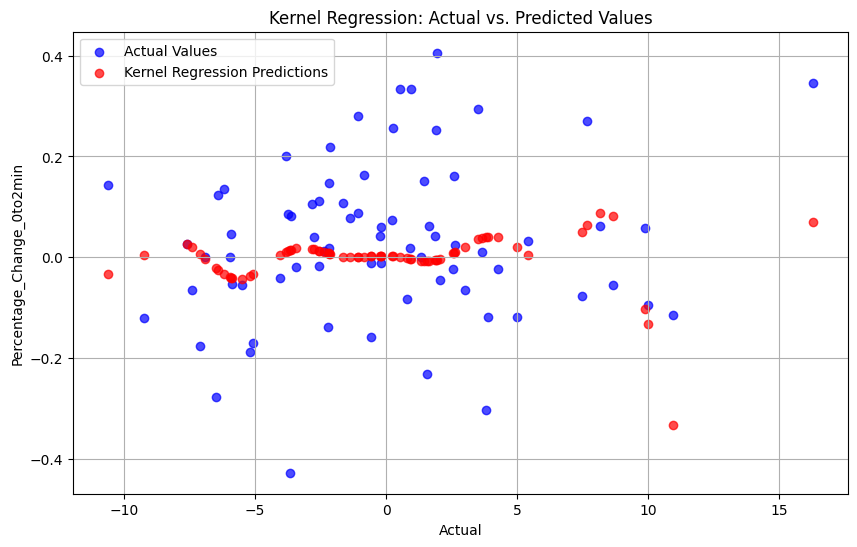

In [292]:

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Extract the relevant columns
X = date_percentage_change_df_sorted[['Actual']]
y = date_percentage_change_df_sorted['Percentage_Change_0to2min']

# Split data into training and testing sets for robust evaluation.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Define the parameter grid to search over.
# We'll focus on alpha (regularization strength) and gamma (kernel width)
param_grid = {
    "alpha": np.logspace(-3, 3, 7), # Regularization strength
    "gamma": np.logspace(-3, 3, 7)  # Kernel width, inverse of RBF sigma
}

# Initialize Kernel Ridge Regressor with Gaussian kernel
kernel_reg = KernelRidge(kernel='rbf')

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(kernel_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1) # Use negative MSE as GridSearchCV maximizes score

# Fit the model using the training data
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_kernel_reg = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_test = best_kernel_reg.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"Best Kernel Regression model (Gaussian Kernel) with hyperparameters: {grid_search.best_params_}")
print(f"Mean Squared Error on Test Set: {mse_test:.4f}")
print(f"R-squared on Test Set: {r2_test:.4f}")

# Now best_kernel_reg is your fitted Kernel Regression model with the best hyperparameters.
# You can use best_kernel_reg to predict 'Percentage_Change_0to2min' for new 'Actual' values.
# For example, to predict for a new 'Actual' value of -15:
new_actual_value = np.array([[-15]]) # Needs to be in the shape (n_samples, n_features)
predicted_percentage_change = best_kernel_reg.predict(new_actual_value)
print(f"Predicted Percentage Change for Actual Value -15: {predicted_percentage_change[0]:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(X_test['Actual'], y_test, color='blue', label='Actual Values', alpha=0.7) # Plot actual values
plt.scatter(X_test['Actual'], y_pred_test, color='red', label='Kernel Regression Predictions', alpha=0.7) # Plot predictions
plt.xlabel('Actual')
plt.ylabel('Percentage_Change_0to2min')
plt.title('Kernel Regression: Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

Best Kernel Regression model (Gaussian Kernel) with hyperparameters: {'alpha': np.float64(1000.0), 'gamma': np.float64(10.0)}
Mean Squared Error on Test Set: 0.0375
R-squared on Test Set: -0.0241
Predicted Percentage Change for Actual Value -15: 0.0000


c:\Users\evans\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but KernelRidge was fitted with feature names



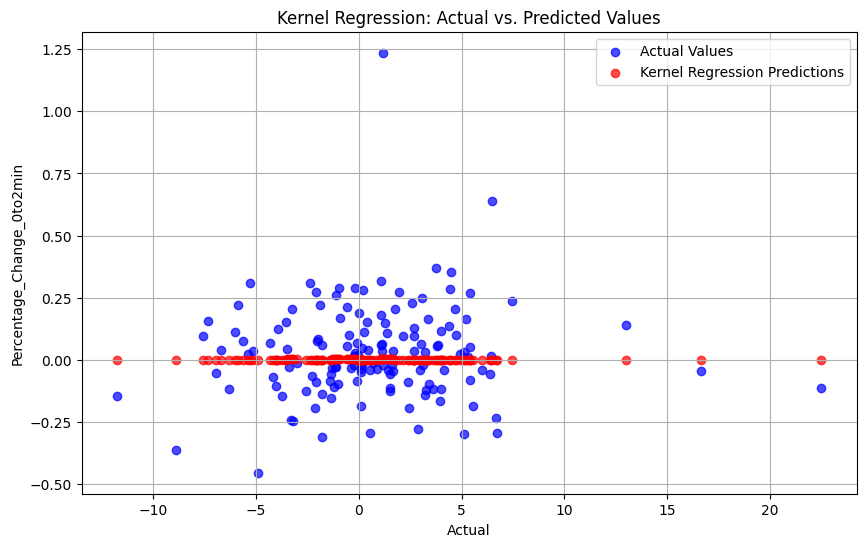

In [ ]:

# Extract the relevant columns
X = date_percentage_change_df[['supply_surprise']]
y = date_percentage_change_df['Percentage_Change_0to2min']

# Split data into training and testing sets for robust evaluation.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid to search over.
# We'll focus on alpha (regularization strength) and gamma (kernel width)
param_grid = {
    "alpha": np.logspace(-3, 3, 7), # Regularization strength
    "gamma": np.logspace(-3, 3, 7)  # Kernel width, inverse of RBF sigma
}

# Initialize Kernel Ridge Regressor with Gaussian kernel
kernel_reg = KernelRidge(kernel='rbf')

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(kernel_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1) # Use negative MSE as GridSearchCV maximizes score

# Fit the model using the training data
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_kernel_reg = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_test = best_kernel_reg.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"Best Kernel Regression model (Gaussian Kernel) with hyperparameters: {grid_search.best_params_}")
print(f"Mean Squared Error on Test Set: {mse_test:.4f}")
print(f"R-squared on Test Set: {r2_test:.4f}")

# Now best_kernel_reg is your fitted Kernel Regression model with the best hyperparameters.
# You can use best_kernel_reg to predict 'Percentage_Change_0to2min' for new 'Actual' values.
# For example, to predict for a new 'Actual' value of -15:
new_actual_value = np.array([[-15]]) # Needs to be in the shape (n_samples, n_features)
predicted_percentage_change = best_kernel_reg.predict(new_actual_value)
print(f"Predicted Percentage Change for Actual Value -15: {predicted_percentage_change[0]:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(X_test['supply_surprise'], y_test, color='blue', label='Actual Values', alpha=0.7) # Plot actual values
plt.scatter(X_test['supply_surprise'], y_pred_test, color='red', label='Kernel Regression Predictions', alpha=0.7) # Plot predictions
plt.xlabel('Actual')
plt.ylabel('Percentage_Change_0to2min')
plt.title('Kernel Regression: Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

Best Kernel Regression model (Gaussian Kernel) with hyperparameters: {'alpha': np.float64(100.0), 'gamma': np.float64(1.0)}
Mean Squared Error on Test Set: 0.0299
R-squared on Test Set: 0.0027
Predicted Percentage Change for Actual Value -15: 0.0000


c:\Users\evans\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but KernelRidge was fitted with feature names



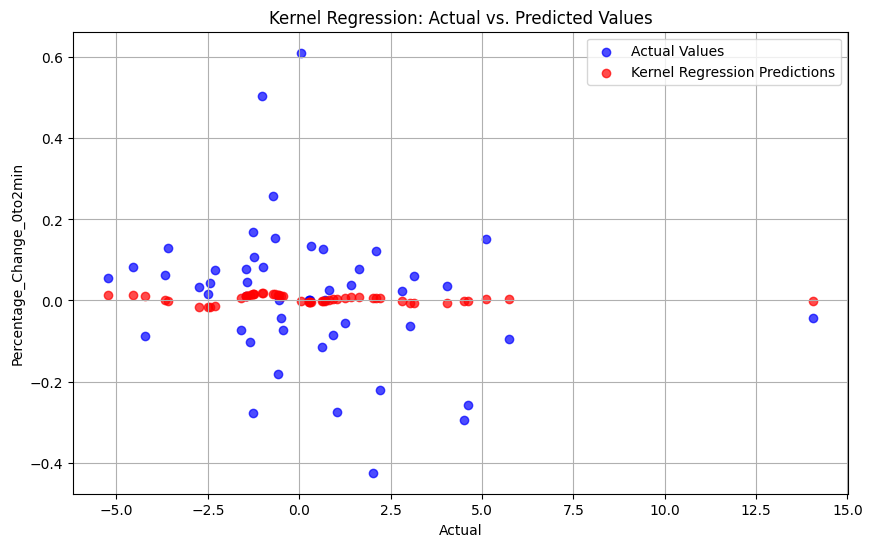

In [ ]:

# Extract the relevant columns
X = date_percentage_change_df_api_sorted[['supply_surprise']]
y = date_percentage_change_df_api_sorted['Percentage_Change_0to2min']

# Split data into training and testing sets for robust evaluation.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

# Define the parameter grid to search over.
# We'll focus on alpha (regularization strength) and gamma (kernel width)
param_grid = {
    "alpha": np.logspace(-3, 3, 7), # Regularization strength
    "gamma": np.logspace(-3, 3, 7)  # Kernel width, inverse of RBF sigma
}

# Initialize Kernel Ridge Regressor with Gaussian kernel
kernel_reg = KernelRidge(kernel='rbf')

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(kernel_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1) # Use negative MSE as GridSearchCV maximizes score

# Fit the model using the training data
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_kernel_reg = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_test = best_kernel_reg.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"Best Kernel Regression model (Gaussian Kernel) with hyperparameters: {grid_search.best_params_}")
print(f"Mean Squared Error on Test Set: {mse_test:.4f}")
print(f"R-squared on Test Set: {r2_test:.4f}")
# Now best_kernel_reg is your fitted Kernel Regression model with the best hyperparameters.
# You can use best_kernel_reg to predict 'Percentage_Change_0to2min' for new 'Actual' values.
# For example, to predict for a new 'Actual' value of -15:
new_actual_value = np.array([[-15]]) # Needs to be in the shape (n_samples, n_features)
predicted_percentage_change = best_kernel_reg.predict(new_actual_value)
print(f"Predicted Percentage Change for Actual Value -15: {predicted_percentage_change[0]:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(X_test['supply_surprise'], y_test, color='blue', label='Actual Values', alpha=0.7) # Plot actual values
plt.scatter(X_test['supply_surprise'], y_pred_test, color='red', label='Kernel Regression Predictions', alpha=0.7) # Plot predictions
plt.xlabel('Actual')
plt.ylabel('Percentage_Change_0to2min')
plt.title('Kernel Regression: Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

     Actual  Percentage_Change_0to2min  LOESS_Fitted_Percentage_Change
34  -17.049                  -0.396187                        0.037081
189 -14.513                   0.043281                        0.031466
607 -12.788                   0.118263                        0.028019
252 -12.633                   0.068269                        0.027762
713 -12.580                   0.111235                        0.027676
..      ...                        ...                             ...
215  15.189                  -0.043840                       -0.020772
339  16.283                   0.345843                       -0.025791
241  18.962                   0.540897                       -0.036381
343  19.248                   0.253165                       -0.037301
49   21.563                  -0.115397                       -0.043569

[727 rows x 3 columns]
Mean Squared Error (MSE) of the LOESS model: 0.031684
R-squared (R2) of the LOESS model: 0.000171


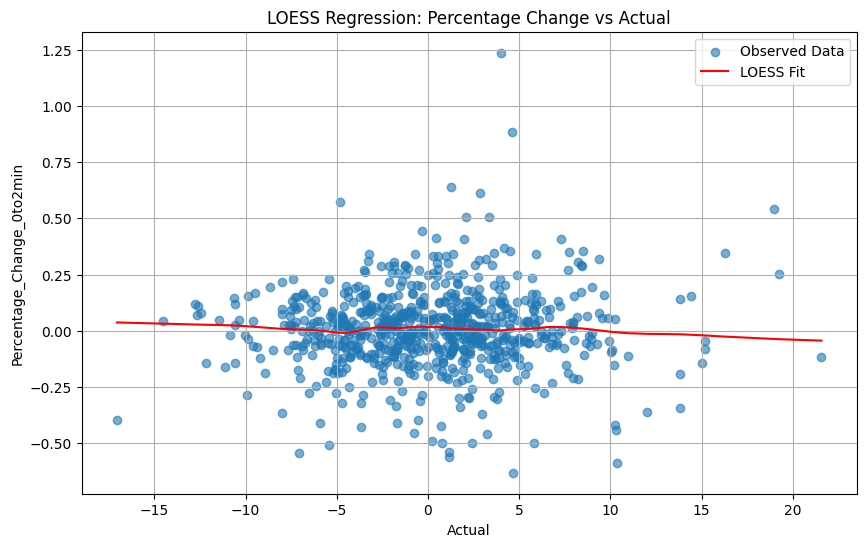

In [295]:
y = date_percentage_change_df_sorted['Percentage_Change_0to2min']
X = date_percentage_change_df_sorted['Actual']

# Fit LOESS model
lowess = sm.nonparametric.lowess(y, X, frac=0.3) # frac is the fraction of data points used for smoothing

# The lowess function returns a tuple of (x, fitted_y).
# Let's unpack it into x_fitted and y_fitted for clarity, although x_fitted here will be the same as sorted X.
x_fitted = lowess[:, 0]
y_fitted = lowess[:, 1]


# You can add the fitted values back to your DataFrame if needed
date_percentage_change_df_sorted['LOESS_Fitted_Percentage_Change'] = np.interp(X, x_fitted, y_fitted)

print(date_percentage_change_df_sorted[['Actual', 'Percentage_Change_0to2min', 'LOESS_Fitted_Percentage_Change']])
mse_loess = mean_squared_error(y, date_percentage_change_df_sorted['LOESS_Fitted_Percentage_Change'])
r2_loess = r2_score(y, date_percentage_change_df_sorted['LOESS_Fitted_Percentage_Change'])

print(f"Mean Squared Error (MSE) of the LOESS model: {mse_loess:.6f}")
print(f"R-squared (R2) of the LOESS model: {r2_loess:.6f}")

plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Observed Data', alpha=0.6)
plt.plot(x_fitted, y_fitted, color='red', label='LOESS Fit')
plt.xlabel('Actual')
plt.ylabel('Percentage_Change_0to2min')
plt.title('LOESS Regression: Percentage Change vs Actual')
plt.legend()
plt.grid(True)
plt.show()

In [291]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score


# 1. Prepare the data
X = date_percentage_change_df_sorted[['Actual']] # Feature
y = date_percentage_change_df_sorted['Percentage_Change_0to2min'] # Target

# 2. Split data into training and testing sets (for robust evaluation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 20% test set, random state for reproducibility

# 3. Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42) # 100 trees is a good starting point
rf_model.fit(X_train, y_train)

# 4. Train an XGBoost Regressor
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42) #  'reg:squarederror' for regression
xgb_model.fit(X_train, y_train)

# 5. Make predictions
rf_predictions = rf_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)

# 6. Evaluate the models
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

print("Random Forest Regressor Performance:")
print(f"  Mean Squared Error: {rf_mse:.4f}")
print(f"  R-squared: {rf_r2:.4f}")

print("\nXGBoost Regressor Performance:")
print(f"  Mean Squared Error: {xgb_mse:.4f}")
print(f"  R-squared: {xgb_r2:.4f}")



Random Forest Regressor Performance:
  Mean Squared Error: 0.0394
  R-squared: -0.3362

XGBoost Regressor Performance:
  Mean Squared Error: 0.0369
  R-squared: -0.2522


Best Random Forest Regressor Performance (after GridSearchCV):
  Mean Squared Error: 0.0293
  R-squared: 0.0040
  Best parameters: {'max_depth': 1, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 50}

Best XGBoost Regressor Performance (after GridSearchCV):
  Mean Squared Error: 0.0295
  R-squared: -0.0014
  Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.005, 'max_depth': 11, 'n_estimators': 10, 'subsample': 0.5}


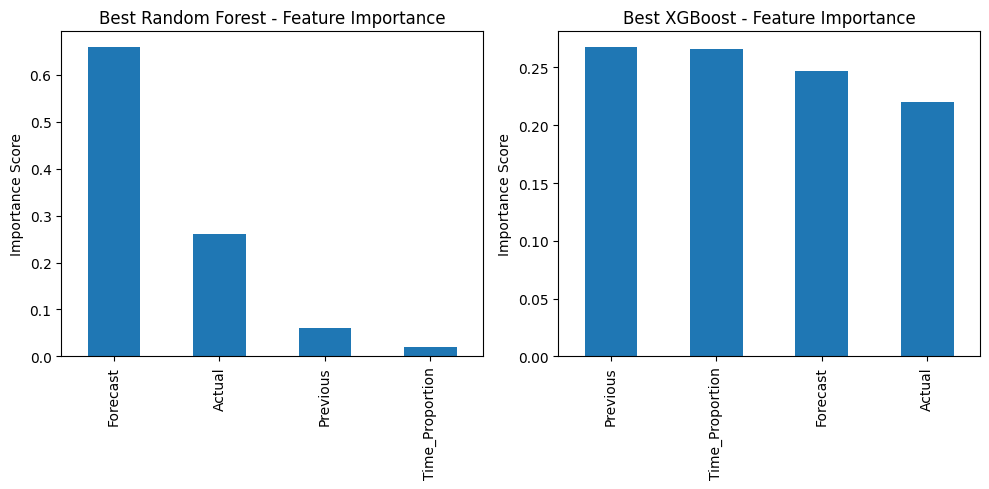

C:\Users\evans\AppData\Local\Temp\ipykernel_23536\2681736804.py:105: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.

C:\Users\evans\AppData\Local\Temp\ipykernel_23536\2681736804.py:113: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.



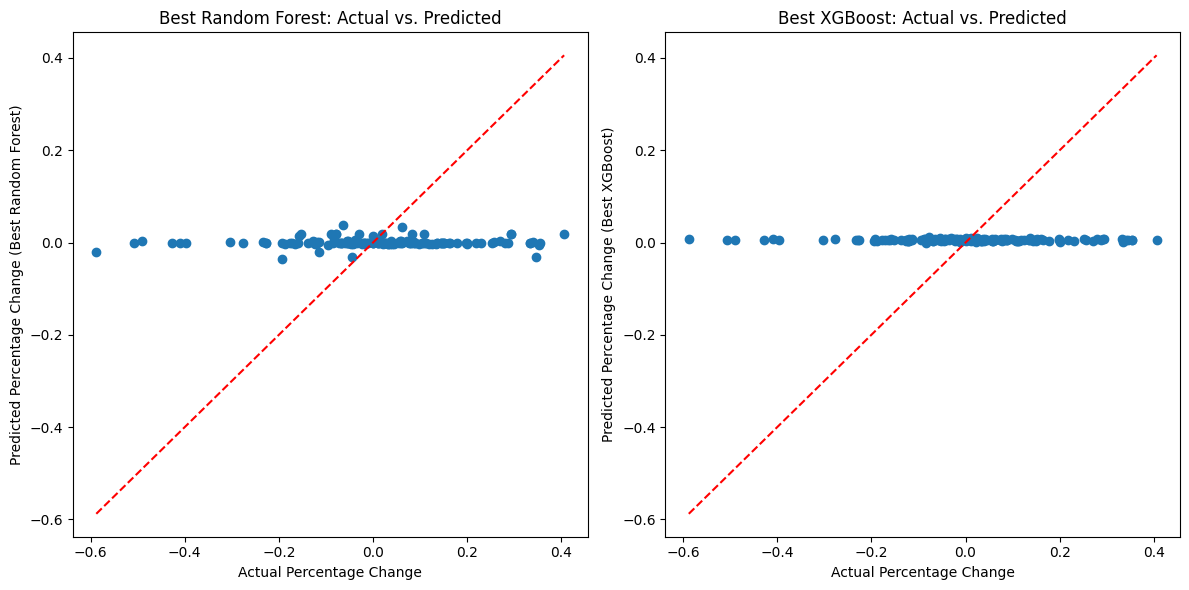

In [300]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score


X = date_percentage_change_df_sorted[['Actual', 'Forecast', 'Previous', 'Time_Proportion']] # Feature
y = date_percentage_change_df_sorted['Percentage_Change_0to2min'] # Target

# 2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Hyperparameter Tuning with GridSearchCV ---

# Define hyperparameter grids to search
param_grid_rf = {
    'n_estimators': [40, 50, 60],
    'max_depth': [None, 1, 2],
    'min_samples_split': [10, 11, 12, 13],
    'min_samples_leaf': [2, 3, 4, 5]
}

param_grid_xgb = {
    'n_estimators': [10, 15, 20, 25],
    'max_depth': [1, 3, 5, 7, 9, 11],
    'learning_rate': [0.0001, 0.001, 0.005],
    'subsample': [0.5, 0.6, 0.7],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid_rf,
                           scoring='neg_mean_squared_error', # For regression, GridSearchCV maximizes score, so use negative MSE
                           cv=3, # 3-fold cross-validation
                           n_jobs=-1) # Use all available cores for parallel processing if possible
grid_search_rf.fit(X_train, y_train)
best_rf_model = grid_search_rf.best_estimator_ # Get the best model from GridSearchCV

# GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
                            param_grid=param_grid_xgb,
                            scoring='neg_mean_squared_error',
                            cv=3,
                            n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
best_xgb_model = grid_search_xgb.best_estimator_ # Get the best model from GridSearchCV


# 5. Make predictions with the best models
rf_predictions = best_rf_model.predict(X_test)
xgb_predictions = best_xgb_model.predict(X_test)

# 6. Evaluate the best models
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

print("Best Random Forest Regressor Performance (after GridSearchCV):")
print(f"  Mean Squared Error: {rf_mse:.4f}")
print(f"  R-squared: {rf_r2:.4f}")
print(f"  Best parameters: {grid_search_rf.best_params_}") # Print best parameters

print("\nBest XGBoost Regressor Performance (after GridSearchCV):")
print(f"  Mean Squared Error: {xgb_mse:.4f}")
print(f"  R-squared: {xgb_r2:.4f}")
print(f"  Best parameters: {grid_search_xgb.best_params_}") # Print best parameters


# --- 1. Feature Importance Plots (using best models) ---

plt.figure(figsize=(10, 5))

# Best Random Forest Feature Importance
plt.subplot(1, 2, 1)
rf_feature_importance = pd.Series(best_rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
rf_feature_importance.plot(kind='bar')
plt.title('Best Random Forest - Feature Importance')
plt.ylabel('Importance Score')

# Best XGBoost Feature Importance
plt.subplot(1, 2, 2)
xgb_feature_importance = pd.Series(best_xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
xgb_feature_importance.plot(kind='bar')
plt.title('Best XGBoost - Feature Importance')
plt.ylabel('Importance Score')

plt.tight_layout()
plt.show()


# --- 2. Prediction vs. Actual Plots (using best models) ---

plt.figure(figsize=(12, 6))

# Best Random Forest Predictions vs. Actual
plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_predictions)
plt.xlabel('Actual Percentage Change')
plt.ylabel('Predicted Percentage Change (Best Random Forest)')
plt.title('Best Random Forest: Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')

# Best XGBoost Predictions vs. Actual
plt.subplot(1, 2, 2)
plt.scatter(y_test, xgb_predictions)
plt.xlabel('Actual Percentage Change')
plt.ylabel('Predicted Percentage Change (Best XGBoost)')
plt.title('Best XGBoost: Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')

plt.tight_layout()
plt.show()